# 
# <u><b>0) Pré-requis pour la bonne exécution du Notebook.</b></u>

## 
## <b><u>0.1) Ensemble des variables à modifier en début d'exécution du Notebook, selon l'exploitation qu'on veut en faire.</u></b>

In [182]:
# Booléen d'activation (ou non) de l'installation des modules/librairies nécessaires au bon fonctionnement de ce Notebook (cf partie 1.1) du Notebook).
installation = False

### Tout ce qui concerne la base de donnée
# Nom du fichier sous lequel est sauvegardée la base de donnée initiale.
title_b2d = 'QueryResults_01.csv'
# Chemin de données (local) vers me répertoire de rangement de la base de donnée initiale, telle que disponible en ligne (cf partie 2) du Notebook).
abs_path_b2d = "../B2D/"#"C:/Users/luked/Documents/Formation_Ingenieur_ML/Projets/P5/B2D/"

### Tout ce qui concerne les figures
# Sauvegarde des figures et chemin de données vers répertoire de stockage
sauvegarde_figure, abs_path_fig = (
    False,
    "../Figures/Analyse/V04test_",
)

### Tout ce qui concerne le cache des fichiers (pour ne pas avoir à refaire tous les calculs systématiquement)
# Sauvegarde des figures et chemin de données vers répertoire de stockage
sauvegarde_fichiers, abs_path_cache = (
    False,
    "../Cache_fichiers/Analyse/V04test_",#"C:/Users/luked/Documents/Formation_Ingenieur_ML/Projets/P5/Cache_fichiers/Analyse/V04test_",
)


## <b><u>0.2) Installation de librairies/modules (sautez cette étape si vous les avez déjà sur votre ordinateur).</u></b>
### !!! LA LIBRAIRIE MISSINGNO EST DONNEE EN RESSOURCE DU PROJET N°2. IL FAUDRA PEUT ÊTRE LA METTRE DANS LE MEME REPERTOIRE DE RANGEMENT QUE CE NOTEBOOK !!!
### Lien vers cette librairie : https://github.com/ResidentMario/missingno

In [104]:
# Installation conditionnée au booléen précédent
if installation:
    ! pip install missingno
    ! pip install nltk
    ! pip install beautifulsoup4
    ! pip install wordcloud

## <b><u>0.3) Importations de librairies/modules/fonctions déjà existants.</u></b>

In [105]:
from missingno.missingno import bar, np, pd, plt, sns
### Traitement de données textuelles
import re
import nltk
if 1==0 :
    nltk.download('stopwords')
    nltk.download('wordnet')
from bs4 import BeautifulSoup
from wordcloud import WordCloud
### Sci-kit Learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
### Mesure du temps écoulé
from tqdm import tqdm

## <b><u>0.4) Définitions de fonctions personnelles.</u></b>

In [106]:
def fct_apply(serie, list_lambda_x):
    output_serie = serie.copy(deep=True)
    for lambda_x in list_lambda_x :
        output_serie = output_serie.apply(lambda_x)
    return output_serie

In [107]:
def flatten_serie(serie):
    flattened_serie = pd.Series(np.concatenate((serie.values)))
    return flattened_serie

In [108]:
def tokens_to_string(list_of_tokens):
    string = list_of_tokens[0]
    for n in range(1,len(list_of_tokens)):
        string += ' '+list_of_tokens[n]
    return string

In [156]:
def plot_most_freq_tokens(nb, tokenized_serie, title, rotation):
    serie = flatten_serie(tokenized_serie)
    plt.figure(title, figsize=(20,7)), plt.clf()
    axe = plt.subplot(1,1,1)
    axe.set_title(f'{nb} (among {serie.unique().shape[0]}) most frequent tokens - {title}', fontdict={'weight':'bold', 'size':18})
    axe.set_ylabel('Frequency', fontdict={'size':18}), axe.set_xlabel('Tokens', fontdict={'size':18})
    axe.bar(x=serie.value_counts()[:nb].index, height=serie.value_counts()[:nb].values)
    axe.set_xticklabels(labels=serie.value_counts()[:nb].index, rotation=rotation, fontsize=15)
    axe.minorticks_on()
    axe.grid(which='both', axis='y')
    del axe, serie

## <b><u>0.5) Définitions de constantes personnelles.</u></b>

In [110]:
# Random State fixé une bonne fois pour toute
rgn = 420
# Liste de base des stop words anglais
stop_w_en = list(set(nltk.corpus.stopwords.words('english')))
# Lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

# 
# 
# <b><u>I) La base de données.</u></b>
## 
## <b><u>I.1) Chargement des données.</u></b>
La base de données a été téléchargée manuellement depuis le site suivant : https://data.stackexchange.com/stackoverflow/query/new. Elle a ensuite été répertoriée en local, mais pas dans le même répertoire que ce notebook.

!!! Part la suite, on y fera référence sous l'abréviation 'B2D' !!!

### La requête SQL utilisée pour télécharger la B2D est celle suggérée dans la page de présentation du projet OpenClassroom :
SELECT TOP 500000 Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount

FROM Posts 

WHERE PostTypeId = 1 AND ViewCount > 10 AND FavoriteCount > 10

AND Score > 5 AND AnswerCount > 0 AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5

In [111]:
# Chargement de la B2D initiale
df_b2d_csv = pd.read_csv(abs_path_b2d + title_b2d)
# Affichage
df_b2d_csv

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,Mercator longitude and latitude calculations t...,<p>I have this image. It's a map of the UK (no...,<javascript><geolocation><projection><processi...,2103924,19,30199,29,10
1,Starting point for learning CAD/CAE file formats?,<p>We are developing some stress and strain an...,<c++><file-format><autocad><cad><solid-bodies>,1024323,6,6097,11,6
2,LINQ query on a DataTable,<p>I'm trying to perform a LINQ query on a Dat...,<c#><.net><linq><datatable><.net-3.5>,10855,1107,1042939,215,22
3,How to overload std::swap(),<p><code>std::swap()</code> is used by many st...,<c++><performance><optimization><stl><c++-faq>,11562,122,34718,50,4
4,How do you get a directory listing in C?,<p>How do you scan a directory for folders and...,<c><file><directory><cross-platform><common-ta...,12489,65,136135,21,9
...,...,...,...,...,...,...,...,...
27123,Can't perform a React state update on an unmou...,<h2>Problem</h2>\n\n<p>I am writing an applica...,<javascript><reactjs><typescript><lodash><sets...,53949393,343,520363,93,27
27124,Can WPF applications be run in Linux or Mac wi...,<p>Microsoft announced .NET Core 3 comes with ...,<linux><wpf><.net-core><desktop-application><....,53954047,82,65594,11,4
27125,Instance of 'SQLAlchemy' has no 'Column' membe...,<p>I'm currently trying to implement steam log...,<python><python-3.x><flask><sqlalchemy><pylint>,53975234,42,39598,18,6
27126,"Why does `if None.__eq__(""a"")` seem to evaluat...",<p>If you execute the following statement in P...,<python><python-3.x><string><boolean-expressio...,53984116,148,5885,24,4


## 
## <b><u>I.2) Analyse sommaire.</u></b>

### <b><u>I.2.a) Remarques générales.</u></b>
Sur l'ensemble des colonnes précédentes, on trouve :
- 3 colonnes de données textuelles ;
- 5 colonnes de données numériques.

Ce sont probablement les colonnes de la 1ère catégorie qui vont constituer le coeur de notre jeu de données. On peut se poser la question de savoir si toutes les autres colonnes vont - ou pas - avoir la moindre utilité pour ce projet. On décide de les garder sous la main pour l'instant, dans le doute... Néanmoins, elles devront nécessairement avoir disparu d'ici à l'approche non suopervisée de création de <i>tags</i>.

### 
### <b><u>I.2.b) Un exemple sur une ligne du rôle des trois colonnes de données textuelles.</u></b>
Annalysons sommairement un exemple de données textuelles via la première ligne de la B2D :

In [112]:
# On parcourt les 3 colonnes concernées et on affiche la chaîne de caractères correspondants.
for col in ['Title','Body','Tags'] :
    print(f'Pour la colonne {col : >10} :\n')
    print(df_b2d_csv.loc[0, col])
    print('\n---------------------\n')

Pour la colonne      Title :

Mercator longitude and latitude calculations to x and y on a cropped map (of the UK)

---------------------

Pour la colonne       Body :

<p>I have this image. It's a map of the UK (not including Southern Ireland):</p>

<p><a href="https://i.stack.imgur.com/KUcpE.png" rel="nofollow noreferrer"><img src="https://i.stack.imgur.com/KUcpE.png" alt="UK Map"></a> </p>

<p>I have successfully managed to get a latitude and longitude and plot it onto this map by taking the leftmost longitude and rightmost longitude of the UK and using them to work out where to put the point on the map.</p>

<p>This is the code (for use in Processing.js but could be used as js or anything):</p>

<pre><code>// Size of the map
int width = 538;
int height = 811;
// X and Y boundaries
float westLong = -8.166667;
float eastLong = 1.762833;
float northLat = 58.666667;
float southLat = 49.95;

void drawPoint(float latitude, float longitude){

 fill(#000000);

 x = width * ((westLong-longi

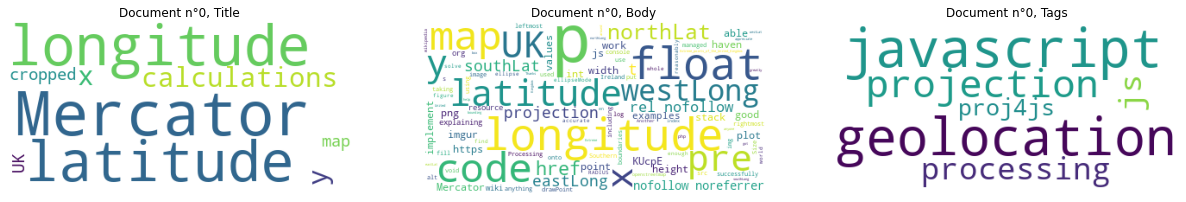

In [113]:
num_doc, tab_col = 0, ['Title','Body','Tags']
plt.figure('zefbaef', figsize=(7*len(tab_col), 7)), plt.clf()
for i, col in enumerate(tab_col):
    axe = plt.subplot(1, len(tab_col), i+1)
    axe.set_title(f'Document n°{num_doc}, {col}'), axe.imshow(WordCloud(background_color = 'white', random_state=rgn, regexp=r'\w+').generate(df_b2d_csv.loc[num_doc, col])), axe.axis('off')
del num_doc, tab_col, i, col, axe

Nous pouvons faire les remarques suivantes :

(1) La dernière colonne <i>Tags</i> est constituée uniquement de quelques mots entre crochets (<i>braket</i>), mélange de termes liés à la programation informatique et à un sujet plus général sur lequel cette programmation pourrait s'appliquer. Il s'agit des mots clés probablement déjà suggérés soit par les utilisateurs, soit par les propres algorithmes de <i>StackOverFlow</i>. >C'est donc une colonne de référence qui constituera au moins notre "vecteur Y" lors de la partie supervisée. 

(2) La première colonne <i>Title</i> est constituée d'un peu plus de mots que <i>Tags</i>, et organisés selon une synthaxe proche de celle d'une phrase (en l'occurence, quelques propositions adverbiales). On y retrouve et y devine les mots clés présents dans <i>Tags</i> concernant le thème général d'application de la programmation informatique, mais aucun indice quant à la programmation en elle-même. (Notons que ceci n'est pas systématique, comme on peut le voir lors de l'affichage de la B2D un peu plus haut où des indications à propos de la programmation informatique en elle même sont présentes, par exemple en lignes 1,2,3,4, etc).

(3) La seconde colonne <i>Body</i> est constituée de BEAUCOUP PLUS de mots que pour les deux autres colonnes. Tout y est explicité, sous forme de phrase en anglais et de lignes de codes, sur de nombreuses lignes de textes. On remarque qu'un grand nombre de balises de formatges sont présentes.

### 
### <b><u>I.2.c) Conséquences sur le travail à faire si ces remarques sont généralisables.</u></b>
Spontanément, on se dit donc qu'il faut chercher les mots clefs au moins sur <i>Body</i>, car dans cet exemple, on voit bien que toutes les informations présentes dans <i>Tags</i> sont présentes dans <i>Body</i>, ou tout du moins déductibles de ce qui s'y trouve, alors que celles présentes au sein de <i>Title</i> ne suffisent pas. 

Cependant, on se rend compte que le très grand nombre de mots présents dans <i>Body</i> risquent de considérablement alourdir notre tâche. On a donc intérêt à trouver un moyen de restreindre au temps que possible nos entrées d'algorithmes aux informations contenues dans <i>Title</i>, et de ne tenir compte de <i>Body</i> qu'en cas d'ultime recours.

## 
## <b><u>I.3) Absences d'informations sur certaines lignes/colonnes ?</u></b>
On se doute qu'il n'y a pas de NaN dans notre B2D, du fait de la façon dont elle a été récupérée (le query SQL suggéré dans l'intitulé du projet), mais on préfère s'en assurer.

<AxesSubplot:>

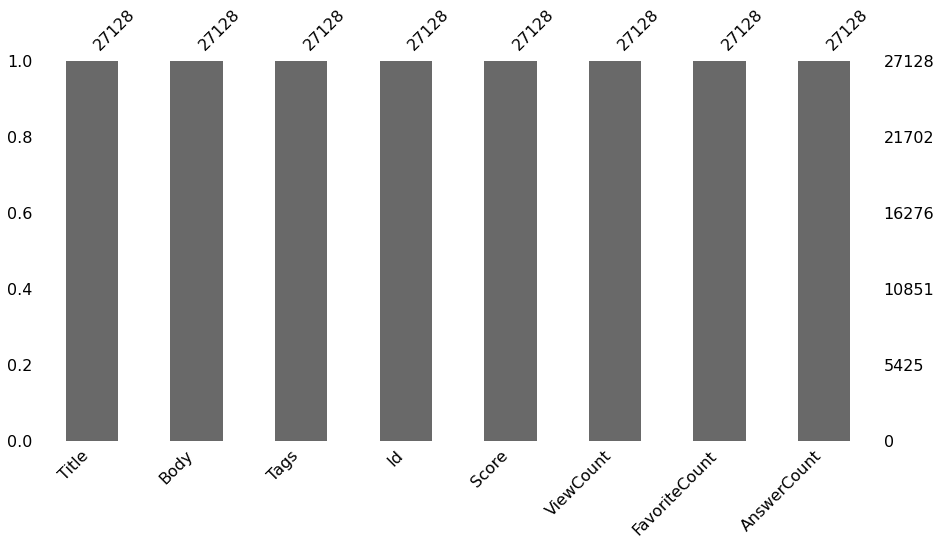

In [114]:
# Densité de remplissage sous forme de diagramme en bar
plt.figure('Densite de remplissage de la B2D originale', figsize=(15,7)), plt.clf()
axe = plt.subplot(1,1,1)
bar(df_b2d_csv, ax=axe)

Bien, il n'y a aucune NaN. Cependant, on sait par expérience qu'on peut facilement remplacer une NaN par une information par défaurt, particulièrement pour les données textuelles où '' est formellement une chaîne de caractère. On va donc s'assurer que ce genre d'intrus n'est pas présent dans la B2D - et éliminer les lignes correspondantes si jamais c'est le cas.

<u>N.B. :</u> cette démarche ne vaut que pour les colonnes <i>Title</i> et <i>Body</i>, car la requête SQL qui a été executée pour extraire cette B2D exclut de fait l'absence de données pour la colonne <i>Tags</i>.

In [115]:
print(['' in df_b2d_csv[col].values for col in ['Title', 'Body']])

[False, False]


###### 
## <u><b>I.4) Reduction du nombre de documents.</b></u>
On s'est rendu compte au cours de ce projet qu'il nous fallait absolument réduire le nombre de documents avec lesquels nous travaillons, sans quoi les calculs - nottamment lors de l'approche surpervisée - sont beaucoup trop longs (par exemple : une nuit entière pour faire une prédiction de 5 mots-clefs par documents pour ~ 20000 documents). On décide donc d'entrée de jeu de diviser par deux notre nombre de documents de travail.

Comment choisir ces documents ? En utilisant les paramètres numériques de la base de données. En effet, ceux-ci vont sans doute nous aider à "choisir" les 50% de documents les + pertinents.

Commençons par afficher les distributions mono-variées et bi-variées des 4 derniers paramètres numériques (<i>Id</i> ne servant qu'à de l'identification de documents).

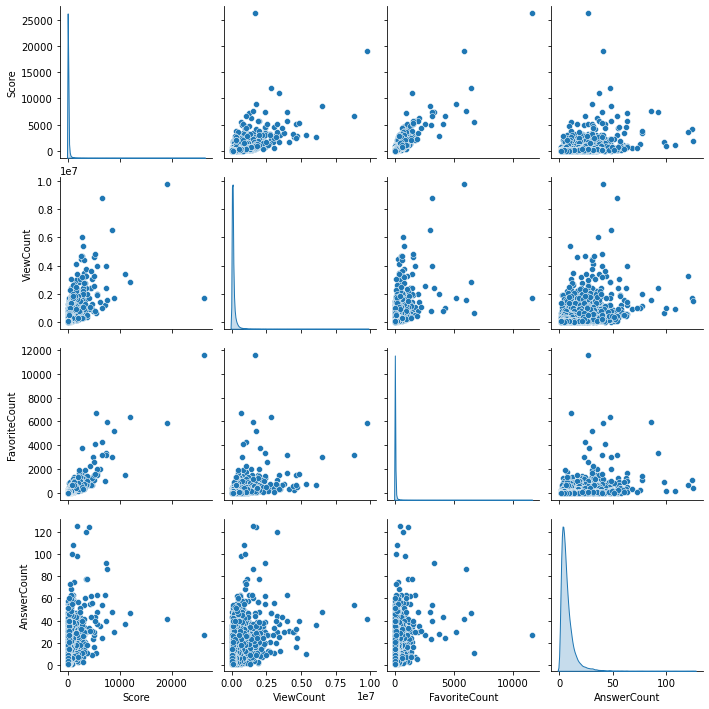

In [116]:
sns.pairplot(data=df_b2d_csv[['Score','ViewCount','FavoriteCount','AnswerCount']], diag_kind='kde')

Tous ces paramètres ont des distributions mono-variées avec un écart-type bien supérieur à leur moyenne/médianne, et possèdent tous des maxima enc ore plus supérieurs.

Les distributions bi-variées ne révèlent pas garnd chose... Si ce n'est qu'on dirait qu'il y a une assez bonne corrélation entre <i>Score</i> et <i>FavoriteCount</i>. Cherchons à confirmer cette impression en affichant la matrice des corrélations de ces 4 paramètres :

In [117]:
df_b2d_csv[['Score','ViewCount','FavoriteCount','AnswerCount']].corr()

,Score,ViewCount,FavoriteCount,AnswerCount
Score,1.000000,0.680333,0.891282,0.396596
ViewCount,0.680333,1.000000,0.510110,0.478100
FavoriteCount,0.891282,0.510110,1.000000,0.315248
AnswerCount,0.396596,0.478100,0.315248,1.000000


C'est bien ce qu'on pensait : le coefficient de corrélation linéaire entre ces deux paramètres est ~0.9, on pourrait même faire une approximation assez bonne en considérant que ces deux paramètres sont totalement corrélés.

<i>Score</i> présente également un coefficient de corrélation assez fort avec <i>ViewCount</i>.

Pour toutes ces raisons, et étant préssés par le temps, on décide d'aller "au plus simple" en alignant notre sélection sur le paramètre <i>Score</i> : on ne gardera que la moitié des documents ayant le meilleur score. Réperons les indices correspondants :

In [118]:
# On crée une variable contenant les indices des documents ayant un score supérieur où égal à sa médiane
ind_scores_supmed = df_b2d_csv[df_b2d_csv['Score']>=df_b2d_csv['Score'].median()].index.values
# On vérifie que ça fasse bien 50% des docuemnts :
print(f'On a sélectionné ainsi {100*len(ind_scores_supmed)/len(df_b2d_csv) : 3.1f}% des documents ayant le meilleur score.')

On a sélectionné ainsi  50.0% des documents ayant le meilleur score.


# 
# <u><b>II) Pré-traitement des colonnes de données textuelles.</b></u>
Avant de procéder à la tokenisation, nous avons quelques étapes à faire subir à nos colonnes de données textuelles. Entre autres pour facailiter la tokenisation et les étapes suivantes de nettoyage (retrait de <i>stop words</i> et <i>lemmatisation</i> notamment)
###### 
## <u><b>II.1) Création de variables de travail, et sélection effectives des documents.</b></u>
On commence par faire une copie (avec deep=True) des 3 premières colonnes, afin de pouvoir toujours revenir aux données originales si besoin est. Ces copies sont directement réduites aux indices des documents sélectionnés en section précédente.

In [119]:
### On procède colonne par colonne, en créant 3 nouvelles variables
title = df_b2d_csv.loc[ind_scores_supmed, 'Title'].copy(deep=True)
body = df_b2d_csv.loc[ind_scores_supmed, 'Body'].copy(deep=True)
tags = df_b2d_csv.loc[ind_scores_supmed, 'Tags'].copy(deep=True)

###### 
## <u><b>II.2) Passages aux minuscules de tous les caractères alphabétiques.</b></u>
Puis on passe toutes les chaînes de carctères en miniscules, afin de ne pas créer artificiellemnt plus de mots qu'il y en a.

In [120]:
title = title.str.lower()
body = body.str.lower()
tags = tags.str.lower()

###### 
## <u><b>II.3) Cas particulier de <i>Body</i> : récupération du texte au sein des balises html.</b></u>


On se souvient que les éléments de <i>Body</i> sont répartis sous forme de texte encapsulés entre des balises html. A ce titre, on reproduit ci-dessous un graphes des balises les plus fréquentes (même si les lignes de codes telles qu'elles sont trapées ci-dessous ne permettent pas de faire la différence entre une balise d'ouverture et une de fermeture).

In [121]:
# Listes de fonctions lambda qu'on va utiliser pour cette nouvelle tokenisation
list_lambda_x = [lambda x : [child.name for child in BeautifulSoup(x, 'html.parser').findChildren()]] 
# Pandas.Series des balises html de chaque ligne de Body
balises = fct_apply(body, list_lambda_x)
# Affichage graphiques du décompte des différentes balises html présentes au sein de Body
flatten_serie(balises).value_counts()#plot_most_freq_tokens(nb=50, tokenized_serie=balises, title='Body, taking on html tags')

p             61329
code          40276
pre           15136
a              8226
li             8068
strong         6901
em             2898
blockquote     1729
ul             1699
br             1379
img            1237
hr              957
ol              835
h2              545
h3              327
h1              230
kbd             224
div             125
td              112
b                91
sup              82
sub              54
tr               40
strike           31
th               23
i                17
s                14
thead             7
table             7
tbody             7
del               6
h4                4
dtype: int64

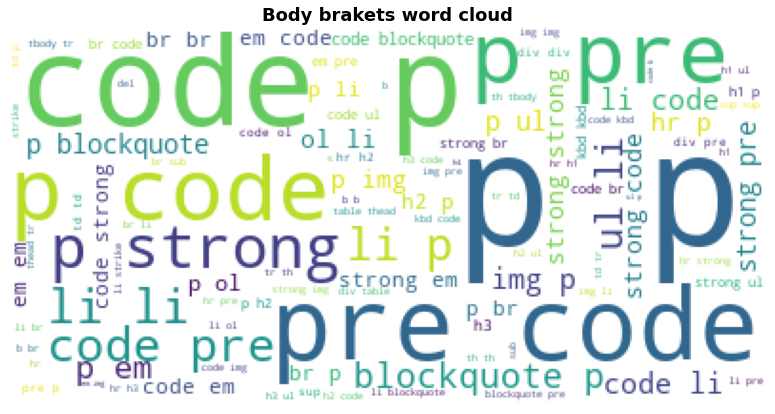

In [130]:
plt.figure('wordcloud balises body', figsize=(15, 7)), plt.clf()
axe = plt.subplot(1, 1, 1)
axe.imshow(WordCloud(background_color = 'white', random_state=rgn).generate(tokens_to_string(flatten_serie(balises).values))), axe.axis('off')
axe.set_title('Body brakets word cloud', fontsize=18, fontweight='bold')
if sauvegarde_figure :
    plt.savefig(abs_path_fig+'01_wordcloud_balises_body.png')
del axe

Il y a une presque une majorité de balises de type <i>p</i>, ce sont celles qui contiennent l'essentiel du texte intéressant pour nous (si on considère qu'il nous faut évacuer, par exemple, les paragraphes entiers de code). 

In [131]:
# Listes de fonctions lambda qu'on va utiliser pour cette nouvelle tokenisation
list_lambda_x = [lambda x : [child.text for child in BeautifulSoup(x, 'html.parser').find_all('p')], 
                 lambda x : tokens_to_string(x) if len(x)>0 else x]
# Applications successives des fonctions lamnbda précédentes
body = fct_apply(body, list_lambda_x)

Au passage, si cela a entièrement vidé certains documents de leur contenu, il faut les retirer du corpus.

In [132]:
if 0 in body.apply(lambda x : len(x)).values :
    print(f'Il y a {len(body[body.apply(lambda x : len(x)==0)])} docuemnts vidés du contenu de leur coprs par cette opération')
    print(f'Soit {100*len(body[body.apply(lambda x : len(x)==0)])/len(body) : 3.1f}% du corpus.')
    print('On procède au retrait de ces documents des trois colonnes Tags, Title et Body.')
    ind_body_vides = body[body.apply(lambda x : len(x)==0)].index.values
    print(f'Il s aggit des documents suivants :\n{ind_body_vides}')
else :
    print('Tout va bien, aucun doucment vidé du contenu de son corps.')
    ind_body_vides = []

Il y a 14 docuemnts vidés du contenu de leur coprs par cette opération
Soit  0.1% du corpus.
On procède au retrait de ces documents des trois colonnes Tags, Title et Body.
Il s aggit des documents suivants :
[  275  2733  4253  6140  7622 10146 11260 13210 14244 17319 18027 22337
 26147 27127]


In [133]:
if len(ind_body_vides) >= 1 :
    tags.drop(index=ind_body_vides, inplace=True)
    title.drop(index=ind_body_vides, inplace=True)
    body.drop(index=ind_body_vides, inplace=True)

On sauvegardera les colonnes de données textuelles ainsi formatées, et destinée à l'approche supervisée, à la fin de ce notebook.

###### 
Bien, on peut désormais passer à la tokenisation et autres opérations de nettoyages de ces pandas.Series.
On commence par <i>Tags</i> pour les raisons évoquées un peu plus haut en section <b>II.2.b</b>.

# 
# <u><b>III) Tokenisations.</b></u>
######  

## <u><b>III.1) Tokenization de <i>Tags</i>, par séparation selon les crochets.</b></u>
###### 
### <u><b>III.1.a) Séparation selon les crochets.</b></u>
### <u><b>Séparation effective.</b></u>
Vérifions tout d'abord si notre intuition était juste : les crochets sont ils systématiques ?

In [134]:
nb = tags.apply(lambda x : np.logical_and(x.startswith('<'), x.endswith('>'))).sum()
print(f'Il y a {100*nb/tags.shape[0] : >3.0f}% des lignes de Tags qui commencent par < et terminent par >.')
nb = tags.apply(lambda x : len(re.findall(pattern='><', string=x))).sum()
print(f'Il y a {nb/tags.shape[0]+1 : >} paires de crochet <> par ligne de Tags.')

Il y a 100% des lignes de Tags qui commencent par < et terminent par >.
Il y a 5.0 paires de crochet <> par ligne de Tags.


On a montré que l'utilisation de crochets est systématique au sein de cette colonne. Il nous faut donc définir une fonction qui permet de récuperer chaque chaîne de carcatère situées entre deux crochets de sens opposés successifs.

In [135]:
tags_tokens = tags.apply(lambda x : re.split(pattern='><', string=x[1:-1]))
# Affichage du nombre de mots-clefs ainsi séparés, et du nombre de mots uniques
print(f'La tokenisation par séparation selon les crochets a produit\n\t{flatten_serie(tags_tokens).shape[0]} mots-clefs\n\tdont {flatten_serie(tags_tokens).unique().shape[0]} mots-clefs-uniques')
print(f'Soit {100*flatten_serie(tags_tokens).unique().shape[0]/flatten_serie(tags_tokens).shape[0] : >3.1f}% du nombre total de mots-clefs.')
# Affichage de contrôle
tags_tokens

La tokenisation par séparation selon les crochets a produit
	67815 mots-clefs
	dont 8459 mots-clefs-uniques
Soit 12.5% du nombre total de mots-clefs.


2                    [c#, .net, linq, datatable, .net-3.5]
3           [c++, performance, optimization, stl, c++-faq]
4        [c, file, directory, cross-platform, common-ta...
5                 [c#, .net, wcf, web-services, datatable]
6                 [c#, .net, performance, datetime, timer]
                               ...                        
27120      [python, pandas, dataframe, slice, multi-index]
27121    [android, kotlin, kotlin-coroutines, coroutine...
27123    [javascript, reactjs, typescript, lodash, sets...
27124    [linux, wpf, .net-core, desktop-application, ....
27126    [python, python-3.x, string, boolean-expressio...
Name: Tags, Length: 13563, dtype: object

La séparation a été bien faite, au sens qu'elle a d'ailleurs conservé le nombre de mots-clefs par ligne :

In [136]:
tags_tokens.apply(lambda x : len(x)).value_counts()

5    13563
Name: Tags, dtype: int64

On a certes supprimé les crochets, mais on voit que les éléments de ponctuations naturellement présents dans la programmation informatique (les tirets '-', les points '.', etc) créent des distinctions qu'on pourrait considérer comme superflues. Par exemple, en se basant sur les lignes précédentes : est-il vraiment nécessaire de faire la distinction entre python et python-3.x ? Entre c, c++, c# et c++11 ?

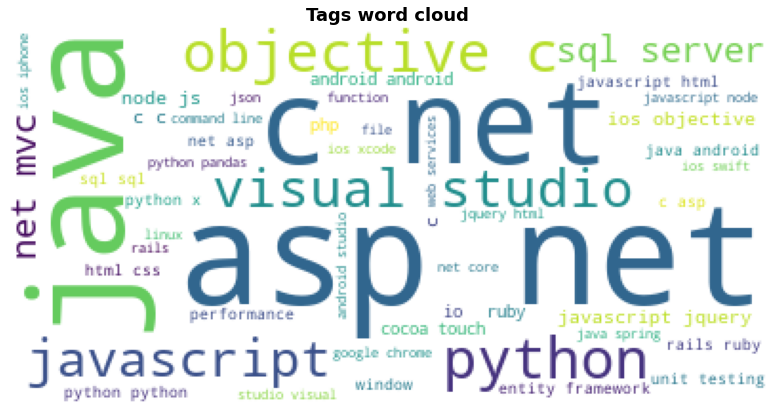

In [151]:
plt.figure('wordcloud tags tokens', figsize=(15, 7)), plt.clf()
axe = plt.subplot(1, 1, 1)
axe.imshow(WordCloud(background_color = 'white', random_state=rgn, max_words=50).generate(tokens_to_string(flatten_serie(tags_tokens).values))), axe.axis('off')
axe.set_title('Tags word cloud', fontsize=18, fontweight='bold')
if sauvegarde_figure :
    plt.savefig(abs_path_fig+'02_wordcloud_tags_tokens.png')
del axe

###### 
### <u><b>Analyse sommaire des mots-celfs ainsi séparés.</b></u>
Faisons une description statistique rapide des mots-clefs :

In [25]:
flatten_serie(tags_tokens).value_counts().describe(np.concatenate((np.arange(0.1,1,0.1),np.arange(0.91,1,0.01))))

count    8459.000000
mean        8.016905
std        45.092819
min         1.000000
10%         1.000000
20%         1.000000
30%         1.000000
40%         1.000000
50%         2.000000
60%         2.000000
70%         3.000000
80%         6.000000
90%        12.000000
91%        14.000000
92%        16.000000
93%        18.000000
94%        21.000000
95%        25.000000
96%        31.000000
97%        39.000000
98%        57.840000
99%        92.840000
max      1558.000000
dtype: float64

La plupart des mots-clefs sont uniques ou presque. Au contraire, quels sont les 100 mots-clefs les plus fréquents, et pour quelle distribuition de fréquence d'apparition ?

<ipython-input-156-7846b9ad72bb>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axe.set_xticklabels(labels=serie.value_counts()[:nb].index, rotation=rotation, fontsize=15)


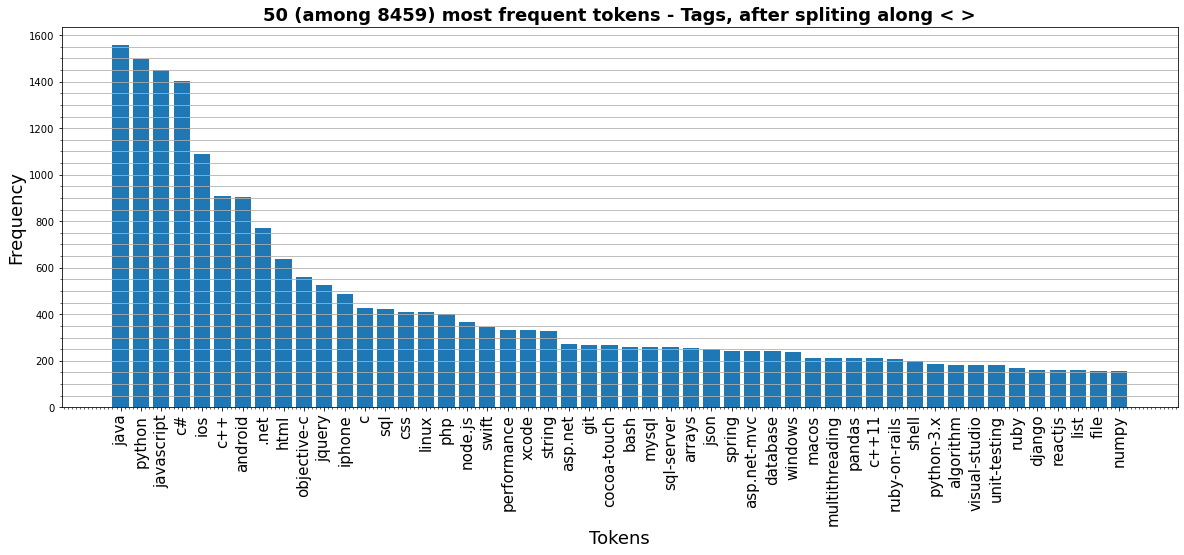

In [157]:
plot_most_freq_tokens(nb=50, tokenized_serie=tags_tokens, title='Tags, after spliting along < >', rotation='vertical')
if sauvegarde_figure :
    plt.savefig(abs_path_fig+'03_tags_tokens_after_splitting.png')

Comme présenti, des termes tels que java, python, c et leurs "dérivés" avec suffixes divers. On voit aussi les forts écart de fréquence, qui chutte très vite sur les ~20 premiers mots. 

A la lumière de l'analyse statistique pérécdente, on comprend que ces 100 mots les + fréquents représentent un infime pourcentage du vocabulaire du corpus [<i>i.e</i>: nombre de mots uniques].

###### 
### <u><b>III.1.b) Combien de mots-clefs présents une seule fois dans le corpus ?</b></u>

### Du coup, en considérant qu'il n'est sans doute pas utile d'avoir autant de mots-clefs si la plupart sont très rares : calculons, pour l'évolution du nombre de documents ne contenant aucun mot-clef rare en fonction de la rareté des mots-clefs.

In [158]:
### Initialisations
# tableau des seuils de rareté & initialisation du tableau qui contiendra un nombre de document par seuil
tab_rarete, tab_nb_doc = np.array([1, 2, 5, 7, 10, 15, 20]), []
# bar de progression
pbar = tqdm(total=len(tab_rarete))
# dictionnaire des fréquences d'apparition
freq = flatten_serie(tags_tokens).value_counts()
### Pour un seuil de rareté donné, calcul du nomre de documents dont les 5 mots-clefs sont TOUS au moins à cette fréquence d'apparition
for rarete in tab_rarete :
    print(f'On en est au seuil de rarete = {rarete : >3.0f} fois présent seulement.')
    # liste des most-clefs au moins à cette fréquence
    liste_mots_frequents = freq.index[freq>=rarete].values
    # calcul effectif du nombre de doc avec 5/5 mots-clefs dans cette liste
    tab_nb_doc.append(tags_tokens.apply(lambda x : np.all([w in liste_mots_frequents for w in x])).sum())
    # MAJ de la br de progression
    pbar.update(1)
    del liste_mots_frequents
del freq, pbar, rarete
# On transforme la liste en tableau
tab_nb_doc = np.array(tab_nb_doc)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

On en est au seuil de rarete =   1 fois présent seulement.


 14%|████████████                                                                        | 1/7 [00:06<00:39,  6.59s/it]

On en est au seuil de rarete =   2 fois présent seulement.


 29%|████████████████████████                                                            | 2/7 [00:10<00:24,  4.88s/it]

On en est au seuil de rarete =   5 fois présent seulement.


 43%|████████████████████████████████████                                                | 3/7 [00:12<00:13,  3.46s/it]

On en est au seuil de rarete =   7 fois présent seulement.


 57%|████████████████████████████████████████████████                                    | 4/7 [00:13<00:07,  2.60s/it]

On en est au seuil de rarete =  10 fois présent seulement.


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:14<00:04,  2.03s/it]

On en est au seuil de rarete =  15 fois présent seulement.


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:15<00:01,  1.63s/it]

On en est au seuil de rarete =  20 fois présent seulement.


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:15<00:00,  1.33s/it]

In [159]:
for i, rarete in enumerate(tab_rarete) :
    print(f'Il y a {tab_nb_doc[i] : >5.0f} documents (soit {100*tab_nb_doc[i]/len(tags_tokens) : >3.0f}% du corpus) qui ne contiennent que des mots-clefs de fréquence d`apparition >={rarete}')
del i

Il y a 13563 documents (soit 100% du corpus) qui ne contiennent que des mots-clefs de fréquence d`apparition >=1
Il y a 10333 documents (soit  76% du corpus) qui ne contiennent que des mots-clefs de fréquence d`apparition >=2
Il y a  6336 documents (soit  47% du corpus) qui ne contiennent que des mots-clefs de fréquence d`apparition >=5
Il y a  5006 documents (soit  37% du corpus) qui ne contiennent que des mots-clefs de fréquence d`apparition >=7
Il y a  3752 documents (soit  28% du corpus) qui ne contiennent que des mots-clefs de fréquence d`apparition >=10
Il y a  2507 documents (soit  18% du corpus) qui ne contiennent que des mots-clefs de fréquence d`apparition >=15
Il y a  1900 documents (soit  14% du corpus) qui ne contiennent que des mots-clefs de fréquence d`apparition >=20


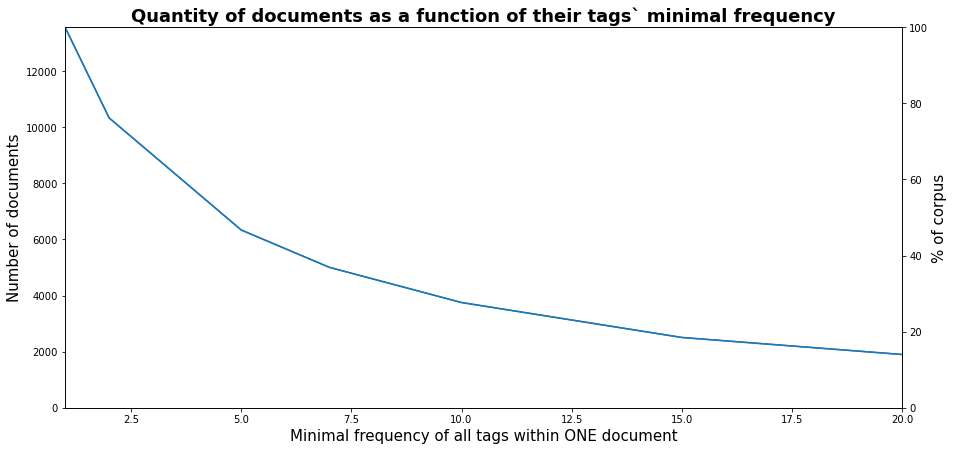

In [173]:
plt.figure('Nb_documents = f(fréquence de ses tags)', figsize=(15,7)), plt.clf()
axe = plt.subplot(111)
axe.set_title('Quantity of documents as a function of their tags` minimal frequency', fontsize=18, fontweight='bold'), axe.set_ylabel('Number of documents', fontsize=15)
axe.plot(tab_rarete, tab_nb_doc), axe.set_ylim([0,len(tags_tokens)]), axe.set_xlim([tab_rarete.min(), tab_rarete.max()]), axe.set_xlabel('Minimal frequency of all tags within ONE document', fontsize=15)
axe2 = axe.twinx()
axe2.plot(tab_rarete, 100*tab_nb_doc/len(tags_tokens)), axe2.set_ylim([0,100]), axe2.set_xlim([tab_rarete.min(), tab_rarete.max()])
axe2.set_xlabel('Minimal frequency of all tags within ONE document', fontsize=15), axe2.set_ylabel('% of corpus', fontsize=15)
if sauvegarde_figure :
    plt.savefig(abs_path_fig+'04_nbdoc=f(freq).png')
del axe, axe2

######  
### <u><b>III.1.c) Analyse de la simultanéité de certains mots-clefs au sein des mêmes documents.</b></u>

In [174]:
n_start = 1 if 'uniquetag' in flatten_serie(tags_tokens).unique() else 0
print('Mots-clefs les + fréquents : [(mot-clef présent dans les mêmes documents, fréquence de co-apparition)]\n')
for mot_clef in flatten_serie(tags_tokens).value_counts()[n_start:20+n_start].index :
    top_co_freq = flatten_serie(tags_tokens[tags_tokens.apply(lambda x : mot_clef in x)]).value_counts()[1:8]
    print(f'{mot_clef : >15} : {[(mot, nb) for mot, nb in zip(top_co_freq.index, top_co_freq.values)]}')
del mot_clef, top_co_freq

Mots-clefs les + fréquents : [(mot-clef présent dans les mêmes documents, fréquence de co-apparition)]

           java : [('android', 215), ('spring', 200), ('jpa', 121), ('hibernate', 118), ('java-8', 93), ('eclipse', 74), ('spring-mvc', 67)]
         python : [('pandas', 206), ('python-3.x', 175), ('numpy', 149), ('dataframe', 122), ('django', 118), ('python-2.7', 73), ('list', 72)]
     javascript : [('jquery', 407), ('html', 316), ('node.js', 212), ('css', 151), ('ajax', 94), ('reactjs', 93), ('angularjs', 88)]
             c# : [('.net', 606), ('asp.net', 163), ('asp.net-mvc', 123), ('wpf', 103), ('visual-studio', 71), ('entity-framework', 69), ('linq', 65)]
            ios : [('objective-c', 411), ('iphone', 336), ('swift', 273), ('xcode', 242), ('cocoa-touch', 202), ('ipad', 58), ('uikit', 58)]
            c++ : [('c++11', 208), ('c', 195), ('gcc', 68), ('stl', 67), ('c++-faq', 65), ('performance', 63), ('language-lawyer', 39)]
        android : [('java', 215), ('android-studio

######  
### <u><b>III.1.d) Analyse de la constitution de mots-clefs à l'aide d'autres mots-clefs (parmis les + fréquents).</b></u>

In [175]:
print('Mots-clefs les + fréquents : [(mot-clef présent dans les mêmes documents, fréquence de co-apparition)]\n')
for mot_clef in flatten_serie(tags_tokens).value_counts()[n_start:20+n_start].index :
    constitue_avec = flatten_serie(tags_tokens)[flatten_serie(tags_tokens).apply(lambda x : mot_clef in x)].value_counts()
    print(f'{mot_clef : >15} : contribue à {len(constitue_avec)-1 : >4.0f} autres mots-clefs, dont :{[(mot, nb) for mot, nb in zip(constitue_avec[1:6].index, constitue_avec[1:6].values)]}')
del mot_clef, constitue_avec

Mots-clefs les + fréquents : [(mot-clef présent dans les mêmes documents, fréquence de co-apparition)]

           java : contribue à   54 autres mots-clefs, dont :[('javascript', 1450), ('java-8', 95), ('java-stream', 33), ('java-time', 16), ('java-7', 16)]
         python : contribue à   57 autres mots-clefs, dont :[('python-3.x', 187), ('python-2.7', 75), ('python-2.x', 30), ('python-internals', 27), ('ipython', 26)]
     javascript : contribue à   11 autres mots-clefs, dont :[('javascript-objects', 6), ('javascript-framework', 4), ('javascriptserializer', 3), ('javascript-intellisense', 1), ('isomorphic-javascript', 1)]
             c# : contribue à    7 autres mots-clefs, dont :[('c#-4.0', 31), ('c#-5.0', 15), ('c#-6.0', 7), ('c#-3.0', 7), ('c#-7.0', 2)]
            ios : contribue à   39 autres mots-clefs, dont :[('ios7', 64), ('ios8', 42), ('ios-simulator', 39), ('ios5', 26), ('ios9', 23)]
            c++ : contribue à   22 autres mots-clefs, dont :[('c++11', 210), ('c++-faq', 6

######  
### <u><b>III.1.f) Présence éventuelles de mots-clefs constitués d'un seul caractère au sein de <i>Tags</i> ?</b></u>

In [176]:
flatten_serie(tags_tokens)[flatten_serie(tags_tokens).apply(lambda x : len(x)==1)].value_counts()

c    428
r    134
q      6
s      1
d      1
dtype: int64

Autant on comprend pourquoi <i>c</i> et <i>r</i> sont présents (ce sont de célèbres langages informatiques), autant la présence de <i>q</i> nous interpelle. Regardons pour quels documents ce mot-clef apparaît :

In [177]:
tags_tokens[tags_tokens.apply(lambda x : 'q' in x)].values, title[tags_tokens.apply(lambda x : 'q' in x)].values, body[tags_tokens.apply(lambda x : 'q' in x)].values

(array([list(['javascript', 'promise', 'q', 'bluebird', 'es6-promise']),
        list(['javascript', 'callback', 'promise', 'q', 'bluebird']),
        list(['javascript', 'promise', 'q', 'bluebird', 'es6-promise']),
        list(['javascript', 'promise', 'q', 'sequential', 'serial-processing']),
        list(['javascript', 'node.js', 'promise', 'this', 'q']),
        list(['javascript', 'node.js', 'promise', 'q', 'bluebird'])],
       dtype=object),
 array(['what is the explicit promise construction antipattern and how do i avoid it?',
        "aren't promises just callbacks?",
        'how do i tell if an object is a promise?',
        'resolve promises one after another (i.e. in sequence)?',
        "why is 'this' undefined inside class method when using promises?",
        'are there still reasons to use promise libraries like q or bluebird now that we have es6 promises?'],
       dtype=object),
 array(['i was writing code that does something that looks like: someone told me this is

OK, il s'agit d'une librairie, potentiellement de <i>javascript</i>.

Il faudra protéger explicitement ces lettres uniques lors des opérations de nettoyages de <i>Title</i> et <i>Body</i>, car on sait que certains algorithme de traitement de texte peuvent ne pas considérer les lettres uniques, quite à les remplacer par des chaînes de carcatères "artificielles" (telles que <i>clang</i>, <i>rlang</i> ou <i>qlibr</i>)

######  
### <u><b>III.1.g) Importance des caractères non alphanumériques parmis les mots-clefs de <i>Tags</i> ?</b></u>
### Recençons les :

In [178]:
# Listes de fonctions lambda qu'on va utiliser pour cette nouvelle tokenisation
list_lambda_x = [lambda x : re.findall(string=x, pattern='\W+')]
# On cherche les chaînes de carctères non alphanumériques parmis les tokens de tags
non_alpha_num_tags = fct_apply(pd.Series(flatten_serie(tags_tokens).unique()), list_lambda_x)
# On ne conserve que les listes avec au moins un carctère non alphanumérique
non_alpha_num_tags = non_alpha_num_tags[non_alpha_num_tags.apply(lambda x : len(x)>0)]
# On fait le décompte :
flatten_serie(non_alpha_num_tags).value_counts()

-      4557
.       368
++       19
++-       8
#-        7
#         6
-.        2
+         1
dtype: int64

### Ils sont présents dans les mots-celfs suivants :

In [179]:
tags_with_W = pd.Series(flatten_serie(tags_tokens).unique()).loc[non_alpha_num_tags.index]
# Affichage
tags_with_W

0                    c#
1                  .net
4              .net-3.5
5                   c++
9               c++-faq
             ...       
8452          fabric.io
8453    cookie-httponly
8454            php-7.3
8455         http-error
8456     signed-integer
Length: 3978, dtype: object

### C'est une liste de taille  importante, et qui compte quelques-uns des mots-clefs les + fréquents. Il faudra protéger ces mots lors des opérations de nettoyage de <i>Title</i> et <i>Body</i>.

In [183]:
tags_with_W.to_csv(abs_path_cache + 'tags_with_W.csv')

## 
## <u><b>III.2) Tokenization de <i>Title</i>.</b></u>
### <u><b>III.2.a) Suppression des caractères non alphabétiques SAUF pour les mots déjà présents au sein des tokens de <i>Tags</i>.</b></u>

In [184]:
# Listes de fonctions lambda qu'on va utiliser pour cette nouvelle tokenisation
list_lambda_x = [lambda x : re.split(string=x, pattern=' '), 
                 lambda x : [[w] if w in tags_with_W.values else re.findall(string=w, pattern='[a-z]+') for w in x], 
                 lambda x : np.concatenate(x)]
# Tokenjsation par applications successives des fonctions lamnbda précédentes
title_tokens = fct_apply(title.loc[tags_tokens.index], list_lambda_x)
# Affichage du nombre de mots ainsi séparés, et du nombre de mots uniques
print(f'La tokenisation définitive de Title a produit\n\t{flatten_serie(title_tokens).shape[0]} tokens\n\tdont {flatten_serie(title_tokens).unique().shape[0]} tokens uniques')
print(f'Soit {100*flatten_serie(title_tokens).unique().shape[0]/flatten_serie(title_tokens).shape[0] : >3.1f}% du nombre total de tokens.')
# Affichage
title_tokens

La tokenisation définitive de Title a produit
	122335 tokens
	dont 9133 tokens uniques
Soit 7.5% du nombre total de tokens.


2                          [linq, query, on, a, datatable]
3                           [how, to, overload, std, swap]
4        [how, do, you, get, a, directory, listing, in, c]
5                    [returning, datatables, in, wcf, net]
6        [is, datetime, now, the, best, way, to, measur...
                               ...                        
27120    [select, rows, in, pandas, multiindex, dataframe]
27121    [suspend, function, callgetapi, should, be, ca...
27123    [can, t, perform, a, react, state, update, on,...
27124    [can, wpf, applications, be, run, in, linux, o...
27126    [why, does, if, none, eq, a, seem, to, evaluat...
Name: Title, Length: 13563, dtype: object

### Toujours par analogie avec la section précédente, affichons les 100 <i>tokens</i> les plus fréquents :

<ipython-input-156-7846b9ad72bb>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axe.set_xticklabels(labels=serie.value_counts()[:nb].index, rotation=rotation, fontsize=15)


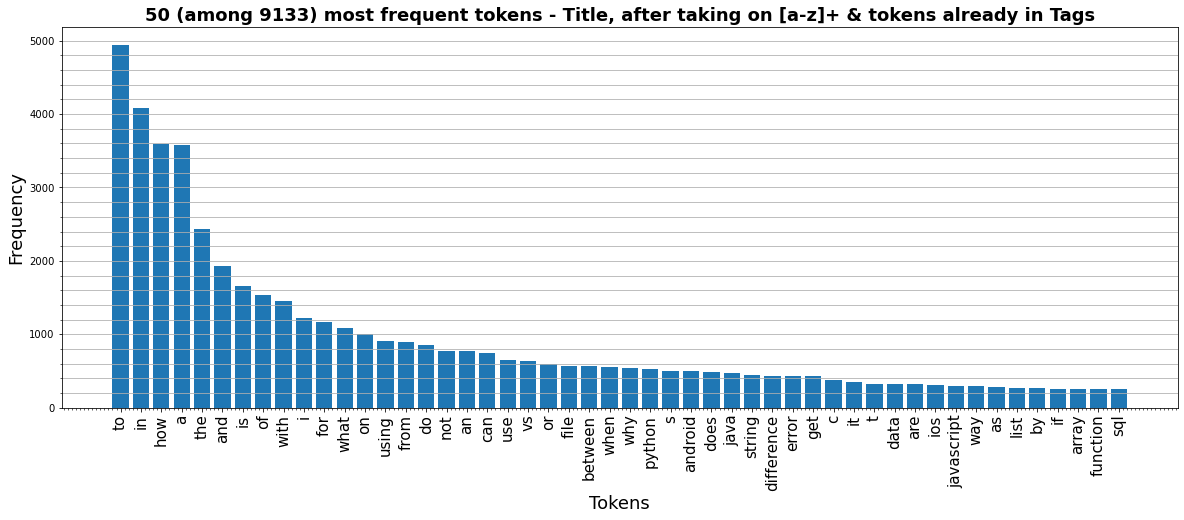

In [185]:
plot_most_freq_tokens(nb=50, tokenized_serie=title_tokens, title='Title, after taking on [a-z]+ & tokens already in Tags', rotation='vertical')

### Les tokens les plus fréquents semblent pour la plupart beaucoup plus "ordinaires" que leurs homologues issues de la tokenisation de <i>Tags</i>. Il se pourrait bien qu'il s'agisse des <i>stop words</i> par défaut de la langue anglaise. 

### 
### <u><b>III.2.b) Importance des <i>stop words</i> anglais au sein des tokens de <i>Title</i>.</b></u>
### Cherchons justement à déterminer le poids des <i>stop words</i> de la langue anglaise (tels que définits par défaut dans NLTK.corpus).

In [186]:
# liste des stop words anglais présents dans le vocabulaire de Title
stop_w_en_in_title = np.intersect1d(stop_w_en, flatten_serie(title_tokens).unique())
print('Les stop words anglais présents parmis les tokens de Title sont le suivants :')
print(stop_w_en_in_title,'\n')
print(f'Il y a {100*len(stop_w_en_in_title)/len(stop_w_en) : >3.1f}% des stop words anglais présents parmis les tokens uniques [ie le vocabulaire] du corpus de Title.')
print(f'(Soit {len(stop_w_en_in_title)} tokens uniques sur {len(flatten_serie(title_tokens).unique())}).')
print(f'Au total, les stop words anglais représente {100*flatten_serie(title_tokens).value_counts()[stop_w_en_in_title].sum()/flatten_serie(title_tokens).value_counts().sum():>3.1f}% de tous les tokens de Title.')

Les stop words anglais présents parmis les tokens de Title sont le suivants :
['a' 'about' 'above' 'after' 'again' 'against' 'all' 'am' 'an' 'and' 'any'
 'are' 'aren' 'as' 'at' 'be' 'because' 'been' 'before' 'being' 'below'
 'between' 'both' 'but' 'by' 'can' 'couldn' 'd' 'did' 'didn' 'do' 'does'
 'doesn' 'doing' 'don' 'down' 'during' 'each' 'few' 'for' 'from' 'further'
 'has' 'have' 'haven' 'having' 'he' 'here' 'how' 'i' 'if' 'in' 'into' 'is'
 'isn' 'it' 'its' 'itself' 'just' 'll' 'm' 'me' 'more' 'most' 'my'
 'myself' 'no' 'nor' 'not' 'now' 'o' 'of' 'off' 'on' 'once' 'only' 'or'
 'other' 'our' 'out' 'over' 'own' 're' 's' 'same' 'should' 'shouldn' 'so'
 'some' 'such' 't' 'than' 'that' 'the' 'their' 'them' 'then' 'there'
 'these' 'they' 'this' 'through' 'to' 'too' 'under' 'until' 'up' 'very'
 'was' 'wasn' 'we' 'were' 'what' 'when' 'where' 'which' 'while' 'who'
 'why' 'will' 'with' 'won' 'y' 'you' 'your'] 

Il y a 69.8% des stop words anglais présents parmis les tokens uniques [ie le voca

### Comme on pouvait le craindre, les <i>stop words</i> ont un poids énorme au sein des tokens de <i>Title</i>. En particulier parmis les tokens les plus fréquents :

In [187]:
for n in 10, 50, 100, 500 :
    intersect = np.intersect1d(flatten_serie(title_tokens).value_counts()[stop_w_en_in_title].index, flatten_serie(title_tokens).value_counts()[:n].index)
    print(f'Sur les {n} tokens les + fréquents de Title, {len(intersect)} sont des stop words (soit {100*len(intersect)/n : >3.1f}% de ces {n} tokens.)')

Sur les 10 tokens les + fréquents de Title, 10 sont des stop words (soit 100.0% de ces 10 tokens.)
Sur les 50 tokens les + fréquents de Title, 30 sont des stop words (soit 60.0% de ces 50 tokens.)
Sur les 100 tokens les + fréquents de Title, 40 sont des stop words (soit 40.0% de ces 100 tokens.)
Sur les 500 tokens les + fréquents de Title, 70 sont des stop words (soit 14.0% de ces 500 tokens.)


### Il faudra donc les supprimer avec soin lors de la section qui sera consacrée à la suppression des <i>stop words.</i>

In [188]:
del intersect, stop_w_en_in_title

## 
## <u><b>III.3) Tokenization de <i>Body</i>.</b></u>
### <u><b>III.3.a) Récupération du texte au sein des balises html.</b></u>

In [189]:
pbar = tqdm(total=1)
# Listes de fonctions lambda qu'on va utiliser pour cette nouvelle tokenisation
list_lambda_x = [lambda x : re.split(string=x, pattern=' '), 
                 lambda x : [[w] if w in tags_with_W.values else re.findall(string=w, pattern='[a-z]+') for w in x], 
                 lambda x : np.concatenate(x)]
# Tokenjsation par applications successives des fonctions lamnbda précédentes
body_tokens = fct_apply(body, list_lambda_x)
pbar.update(1)
del pbar
# Affichage du nombre de mots ainsi séparés, et du nombre de mots uniques
print(f'La tokenisation définitive de Body a produit\n\t{flatten_serie(body_tokens).shape[0]} tokens\n\tdont {flatten_serie(body_tokens).unique().shape[0]} tokens uniques')
print(f'Soit {100*flatten_serie(body_tokens).unique().shape[0]/flatten_serie(body_tokens).shape[0] : >3.1f}% du nombre total de tokens.')
# Affichage
body_tokens

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:01<00:00, 61.59s/it]

La tokenisation définitive de Body a produit
	1370593 tokens
	dont 28098 tokens uniques
Soit 2.1% du nombre total de tokens.


2        [i, m, trying, to, perform, a, linq, query, on...
3        [std, swap, is, used, by, many, std, container...
4        [how, do, you, scan, a, directory, for, folder...
5        [i, have, a, wcf, service, from, which, i, wan...
6        [i, need, to, find, a, bottleneck, and, need, ...
                               ...                        
27120    [what, are, the, most, common, pandas, ways, t...
27121    [i, am, calling, suspended, function, from, on...
27123    [i, am, writing, an, application, in, react, a...
27124    [microsoft, announced, .net, core, comes, with...
27126    [if, you, execute, the, following, statement, ...
Name: Body, Length: 13563, dtype: object

<ipython-input-156-7846b9ad72bb>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axe.set_xticklabels(labels=serie.value_counts()[:nb].index, rotation=rotation, fontsize=15)


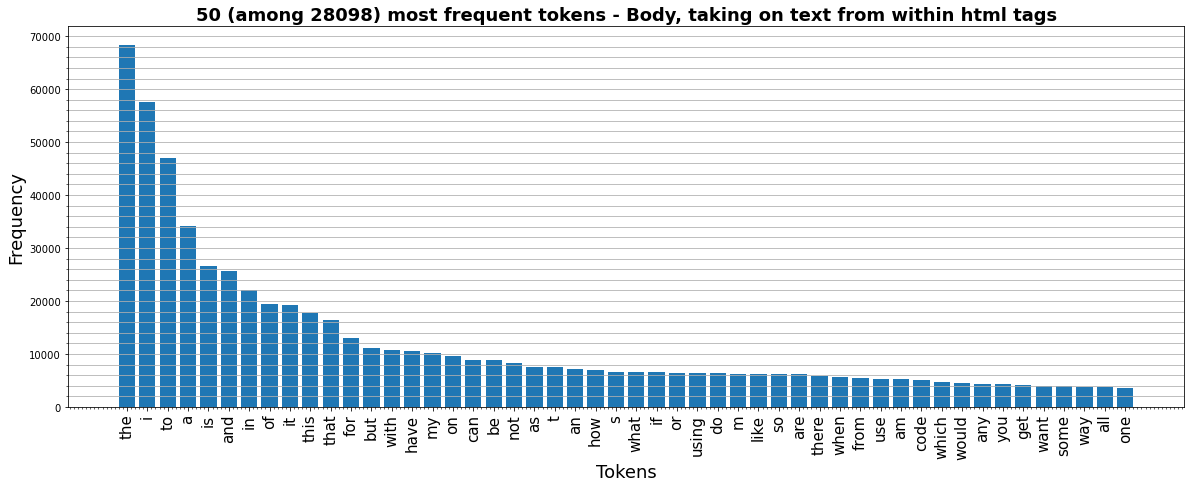

In [190]:
plot_most_freq_tokens(nb=50, tokenized_serie=body_tokens, title='Body, taking on text from within html tags', rotation='vertical')

Comme pour <i>Title</i>, les mots les plus fréquents font pour la plupart partie des <i>stop words</i> par défaut de la langue anglaise.  

In [191]:
del balises, list_lambda_x

### 
### <u><b>III.3.b) Importance des <i>stop words</i> anglais au sein des tokens de <i>Body</i>.</b></u>
Cherchons justement à déterminer le poids des <i>stop words</i> de la langue anglaise (tels que définits par défaut dans NLTK.corpus) au sein de <i>Body</i>. On s'attend à ce qu'il soit encore plus fort que pour <i>Title</i>

In [192]:
# liste des stop words anglais présents dans le vocabulaire de Body
stop_w_en_in_body = np.intersect1d(stop_w_en, flatten_serie(body_tokens).unique())
print('Les stop words anglais présents parmis les tokens de Body sont le suivants :')
print(stop_w_en_in_body,'\n')
print(f'Il y a {100*len(stop_w_en_in_body)/len(stop_w_en) : >3.1f}% des stop words anglais présents parmis les tokens uniques de Body.')
print(f'(Soit {len(stop_w_en_in_body)} tokens uniques sur {len(flatten_serie(body_tokens).unique())}).')
print(f'Au total, les stop words anglais représentent {100*flatten_serie(body_tokens).value_counts()[stop_w_en_in_body].sum()/flatten_serie(body_tokens).value_counts().sum():>3.1f}% de tous les tokens de Body.')

Les stop words anglais présents parmis les tokens de Body sont le suivants :
['a' 'about' 'above' 'after' 'again' 'against' 'ain' 'all' 'am' 'an' 'and'
 'any' 'are' 'aren' 'as' 'at' 'be' 'because' 'been' 'before' 'being'
 'below' 'between' 'both' 'but' 'by' 'can' 'couldn' 'd' 'did' 'didn' 'do'
 'does' 'doesn' 'doing' 'don' 'down' 'during' 'each' 'few' 'for' 'from'
 'further' 'had' 'hadn' 'has' 'hasn' 'have' 'haven' 'having' 'he' 'her'
 'here' 'him' 'himself' 'his' 'how' 'i' 'if' 'in' 'into' 'is' 'isn' 'it'
 'its' 'itself' 'just' 'll' 'm' 'ma' 'me' 'more' 'most' 'mustn' 'my'
 'myself' 'needn' 'no' 'nor' 'not' 'now' 'o' 'of' 'off' 'on' 'once' 'only'
 'or' 'other' 'our' 'ours' 'ourselves' 'out' 'over' 'own' 're' 's' 'same'
 'she' 'should' 'shouldn' 'so' 'some' 'such' 't' 'than' 'that' 'the'
 'their' 'theirs' 'them' 'themselves' 'then' 'there' 'these' 'they' 'this'
 'those' 'through' 'to' 'too' 'under' 'until' 'up' 've' 'very' 'was'
 'wasn' 'we' 'were' 'weren' 'what' 'when' 'where' 'which'

In [193]:
for n in 10, 50, 100, 500 :
    intersect = np.intersect1d(flatten_serie(body_tokens).value_counts()[stop_w_en_in_body].index, flatten_serie(body_tokens).value_counts()[:n].index)
    print(f'Sur les {n} tokens les + fréquents de Body, {len(intersect)} sont des stop words (soit {100*len(intersect)/n : >3.1f}% de ces {n} tokens.)')

Sur les 10 tokens les + fréquents de Body, 10 sont des stop words (soit 100.0% de ces 10 tokens.)
Sur les 50 tokens les + fréquents de Body, 41 sont des stop words (soit 82.0% de ces 50 tokens.)
Sur les 100 tokens les + fréquents de Body, 67 sont des stop words (soit 67.0% de ces 100 tokens.)
Sur les 500 tokens les + fréquents de Body, 109 sont des stop words (soit 21.8% de ces 500 tokens.)


In [194]:
del intersect, stop_w_en_in_body

# 
# <u><b>IV) Retraits des <i>stop words</i>.</b></u>
Dans l'optique de l'approche non supervisée basée sur un <i>bag of words</i>, il nous faut maintenant retirer de nos listes de <i>tokens</i> les fameux <i>stop words</i> apportant peu d'informations. Par la suite, <i>stop words</i> sera abrégé SW.

## <u><b>IV.1) Retraits des <i>stop words</i> de la langue anglaise.</b></u>
On commence par ceux présents par défaut dans NLTK, qui concernent des mots parmis les + courants de la langue anglaise.

In [195]:
list_lambda_x = [lambda x : [w for w in x if w not in stop_w_en]]
#tags_tokens_sw = fct_apply(tags_tokens, list_lambda_x)
title_tokens_sw = fct_apply(title_tokens, list_lambda_x)
body_tokens_sw = fct_apply(body_tokens, list_lambda_x)

<ipython-input-156-7846b9ad72bb>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axe.set_xticklabels(labels=serie.value_counts()[:nb].index, rotation=rotation, fontsize=15)


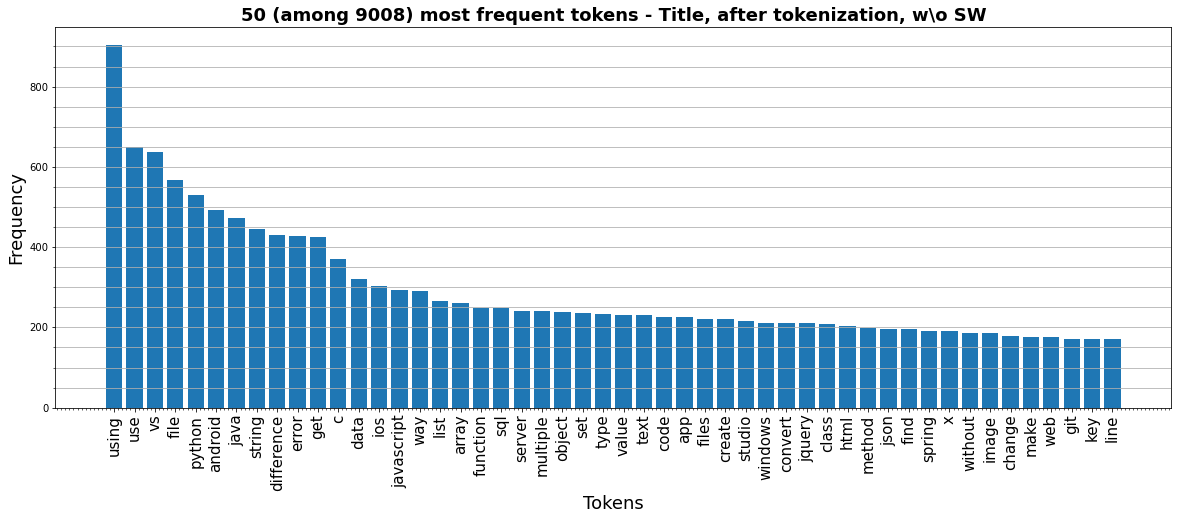

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:38<00:00, 158.02s/it]


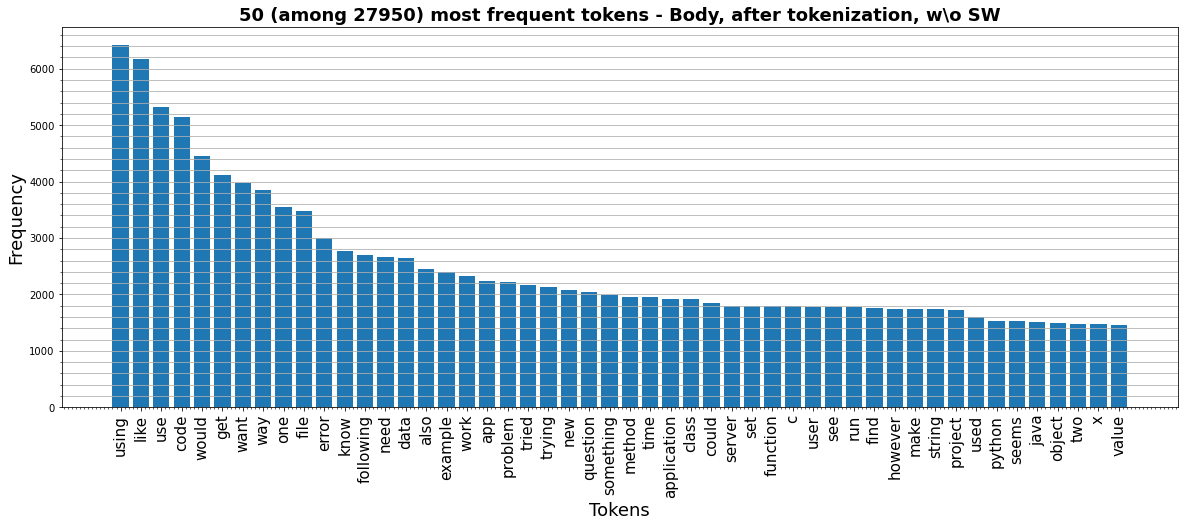

In [196]:
#plot_most_freq_tokens(nb=100, tokenized_serie=tags_tokens_sw, title='Tags, after tokenization, w\o SW', rotation='vertical')
plot_most_freq_tokens(nb=50, tokenized_serie=title_tokens_sw, title='Title, after tokenization, w\o SW', rotation='vertical')
plot_most_freq_tokens(nb=50, tokenized_serie=body_tokens_sw, title='Body, after tokenization, w\o SW', rotation='vertical')

L'effet saute aux yeux : on voit appraître dans le "top 100" de <i>Title</i> et <i>Body</i> des mots bien plus en rapport avec la programmation informatique, on voit même des mots en commun avec le top 100 des mots-clefs de <i>Tags</i> (comme <i>c</i>, <i>android</i>, <i>python</i>, etc).

## 
## <u><b>IV.2) Peut-on trouver des <i>stop words</i> spécifiques à <i>Title</i> et <i>Body</i> ?</b></u>
On pourrait chercher à inclure de nouveaux mots à la liste des SW, à l'image de ce qui est fait dans d'autres projets, en cherchants des mots si récurrents dans les vocabulaire de <i>Title</i> et <i>Body</i> qu'on puissent les considérer comme porteur de finalement peu de spécificité. Par ailleurs, il faudrait que ces mots ne soit pas très fréquents dans les mots-clefs de <i>Tags</i> (voir pas du tout présents) sous peine de déteriorer la liste des mots-clefs sur laquelle in travaillera lors de la partie approche supervisée.

Faisons un exemple : parmis les tokens du top 100 de <i>Title</i> et <i>Body</i>, lesquels et combien d'entre eux ne sont pas présents dans le top 100 de <i>Tags</i> ? Et par ailleurs, quelles sont leurs fréquences d'apparitions dans le vocabulaire entier de <i>Tags</i> ?

In [197]:
nb_top = 100
top_tags = flatten_serie(tags_tokens).value_counts()[:nb_top].index
for serie in [title_tokens_sw, body_tokens_sw]:
    # recherche des nb_top tokens les + fréquents
    top_serie = flatten_serie(serie).value_counts()[:nb_top].index
    # recherche des tokens les + fréquents QUI NE SONT PAS dans le top nb_top des mots-clefs de tags
    not_in_top_tags = [w for w in top_serie if w not in top_tags]
    # recherche des tokens les + fréquents QUI NE SONT MEME PAS DU TOUT dans le VOCABULAIRE de tags
    even_not_in_tags = np.setdiff1d(not_in_top_tags, flatten_serie(tags_tokens).unique(), assume_unique=True)
    # recherche des tokens les + fréquents QUI NE SONT PAS dans le top nb_top des mots-clefs de tags, mais qui sont quand même dans le vocabulaire de tags
    but_in_tags = np.intersect1d(not_in_top_tags, flatten_serie(tags_tokens).unique(), assume_unique=True)
    print(f'Parmis les {nb_top} tokens les + fréquents de {serie.name}, {len(not_in_top_tags)} ne sont pas dans le top{nb_top} de Tags :\n{not_in_top_tags}\n')
    print(f'Il y en a même {len(even_not_in_tags)} qui ne sont pas du tout présents dans le vocabulaire de Tags :\n{even_not_in_tags}')
    print(f'Mais pour les {len(but_in_tags)} qui sont bien présents, la description statistique de leur fréquence d`apparition dans l`ensemble des mots-clefs de Tags est d`ailleurs la suivante :')
    print(flatten_serie(tags_tokens).value_counts()[np.array(but_in_tags)].describe())
    print('\n---------------------------------------------------------------------------------\n')
print(f'Pour information, le {nb_top}ème mot-clef le + fréquent de Tags a une fréquence d`apparition de {flatten_serie(tags_tokens).value_counts()[nb_top]}.')
print('Et la descritpion statistique de la fréquence d`apparition des mots-clefs de Tags est la suivante :')
print(flatten_serie(tags_tokens).value_counts().describe())
del nb_top, top_tags, serie, top_serie, not_in_top_tags, even_not_in_tags, but_in_tags

Parmis les 100 tokens les + fréquents de Title, 65 ne sont pas dans le top100 de Tags :
['using', 'use', 'vs', 'difference', 'error', 'get', 'data', 'way', 'array', 'server', 'multiple', 'set', 'type', 'value', 'text', 'code', 'app', 'files', 'create', 'studio', 'convert', 'method', 'find', 'x', 'without', 'change', 'make', 'web', 'key', 'line', 'view', 'command', 'mvc', 'one', 'add', 'access', 'application', 'visual', 'time', 'best', 'install', 'api', 'column', 'two', 'table', 'std', 'check', 'run', 'name', 'variable', 'element', 'return', 'cannot', 'new', 'work', 'size', 'project', 'default', 'url', 'remove', 'input', 'custom', 'test', 'rails', 'found']

Il y en a même 42 qui ne sont pas du tout présents dans le vocabulaire de Tags :
['use' 'vs' 'error' 'data' 'way' 'array' 'multiple' 'type' 'value' 'code'
 'app' 'files' 'create' 'studio' 'convert' 'method' 'x' 'without' 'change'
 'make' 'mvc' 'one' 'access' 'application' 'visual' 'best' 'install'
 'column' 'two' 'table' 'check' 'run

On voit que la plupart des tokens les + fréquents de <i>Title</i> et <i>Body</i> ne SONT PAS SIMULTANEMENT présents dans le top 100 des mots-clefs de <i>Tags</i>. 
Pire, près de la moitié de ces tokens ne sont MÊME PAS PRESENTS DU TOUT dans le VOCABULAIRE de tags [ceux regroupés sous la variable locale <i>even_not_in_tags</i>; ceux qui sont présents malgré tout dans le vocabulaire de <i>Tags</i> mais hors "top 100" sont regroupés sous <i>but_in_tags</i>].

Deux cas de figure s'offrent alors à nous :

1) Pour ceux présents malgré tout (<i>but_in_tags</i>) : 
Lorsque l'on regarde la description statistique de leurs fréquences d'apparition AU SEIN DE LA DISTRIBUTION DES MOTS CLEFS DE <i>Tags</i>, on se rend compte qu'ils sont relativement fréquent. Donc supprimer ces tokens dans <i>Title</i> et <i>Body</i>, c'est quand même prendre un risque.

2) Pour ceux complétement absents (<i>even_not_in_tags</i>) : 
On peut essayer de faire une selection "manuelle" de tokens à rajouter à laliste des SW, c'est à dire définir des SW spécifiques à notre coprus. On pourrait ainsi y mettre : 
- ceux qui ne concernent pas directement des aspects de programmation/ingénierie informatiques (par exemple : use, using, way, get, would, want, something, also, one, two)
- les chaînes à UN SEUL caractère (hors de "c" et "r" (éponymes de célbères langages de programmation) et "q", toutes trois présentes dans le vocabulaire de <i>Tags</i>)

On commence par reconstituer la liste de l'ensemble des tokens du top100 de <i>Title</i> ET <i>Body</i> même pas inclus dans le vocabulaire de <i>Tags</i>. 

In [198]:
even_not_in_tags = []
### On reproduit les lignes précédentes pour considérer l'ensemble sur Title et Body des tokens 'even not in tags'
nb_top = 100
top_tags = flatten_serie(tags_tokens).value_counts()[:nb_top].index
for serie in [title_tokens_sw, body_tokens_sw]:
    # recherche des nb_top tokens les + fréquents
    top_serie = flatten_serie(serie).value_counts()[:nb_top].index
    # recherche des tokens les + fréquents QUI NE SONT PAS dans le top nb_top des mots-clefs de tags
    not_in_top_tags = [w for w in top_serie if w not in top_tags]
    # recherche des tokens les + fréquents QUI NE SONT MEME PAS DU TOUT dans le VOCABULAIRE de tags
    even_not_in_tags.append(np.setdiff1d(not_in_top_tags, flatten_serie(tags_tokens).unique(), assume_unique=True))
    del top_serie, not_in_top_tags
print(np.unique(np.concatenate(even_not_in_tags)))
del nb_top, serie, top_tags, even_not_in_tags

['able' 'access' 'also' 'another' 'anyone' 'app' 'application' 'array'
 'best' 'cannot' 'change' 'check' 'code' 'column' 'convert' 'could'
 'create' 'custom' 'data' 'different' 'e' 'error' 'even' 'example' 'files'
 'first' 'following' 'found' 'help' 'however' 'install' 'know' 'like'
 'make' 'method' 'multiple' 'mvc' 'name' 'need' 'new' 'one' 'page'
 'possible' 'problem' 'question' 'rails' 'read' 'really' 'remove' 'run'
 'running' 'see' 'seems' 'simple' 'since' 'something' 'still' 'studio'
 'table' 'test' 'thanks' 'tried' 'try' 'trying' 'two' 'type' 'understand'
 'update' 'use' 'used' 'user' 'value' 'variable' 'visual' 'vs' 'want'
 'way' 'without' 'work' 'working' 'works' 'would' 'x']


On peut procéder à la selection "manuelle" de plusieurs d'entre eux pour initialiser notre liste de SW spécéfiques à noter corpus :

In [199]:
stop_w_specifiques = ['use', 'using', 'way', 'get', 'would', 'could', 'new', 'want', 'something', 'also', 'one', 'two']

On y ajoute toutes les caractères composés d'une seule lettre (sauf les 3 présentes parmis les mots-clefs de tags) :

In [200]:
# On ajoute toutes les lettres seules présentes dans Title et Body à la liste des SW spécifiques
lettres_title = flatten_serie(title_tokens_sw)[flatten_serie(title_tokens_sw).apply(lambda x : len(x)==1)].unique()
lettres_body = flatten_serie(body_tokens_sw)[flatten_serie(body_tokens_sw).apply(lambda x : len(x)==1)].unique()

In [201]:
stop_w_specifiques = np.concatenate((stop_w_specifiques, list(lettres_title), list(lettres_body)))
# On retire de cette liste celles présentes dans Tags
stop_w_specifiques = np.unique([w for w in stop_w_specifiques if w not in flatten_serie(tags_tokens)[flatten_serie(tags_tokens).apply(lambda x : len(x)==1)].unique()])
# Affichage
stop_w_specifiques

array(['also', 'b', 'could', 'e', 'f', 'g', 'get', 'h', 'j', 'k', 'l',
       'n', 'new', 'one', 'p', 'something', 'two', 'u', 'use', 'using',
       'v', 'w', 'want', 'way', 'would', 'x', 'z'], dtype='<U9')

In [202]:
del lettres_title, lettres_body

## 
## <u><b>IV.3) Retrait des <i>stop words</i> spécifiques.</b></u>

In [203]:
list_lambda_x = [lambda x : [w for w in x if w not in stop_w_specifiques]]
title_tokens_sw = fct_apply(title_tokens_sw, list_lambda_x)
body_tokens_sw = fct_apply(body_tokens_sw, list_lambda_x)

<ipython-input-156-7846b9ad72bb>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axe.set_xticklabels(labels=serie.value_counts()[:nb].index, rotation=rotation, fontsize=15)


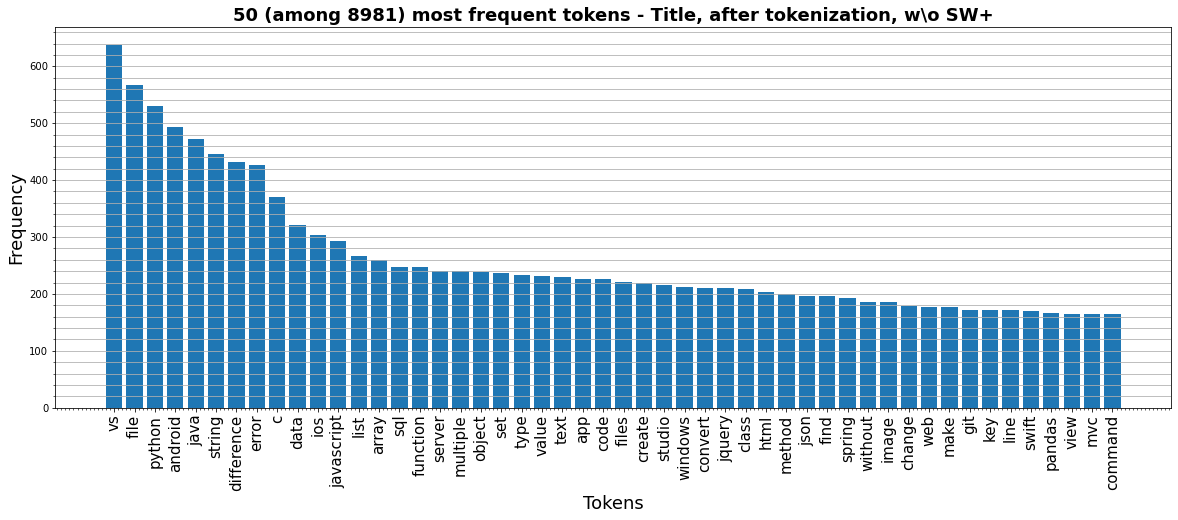

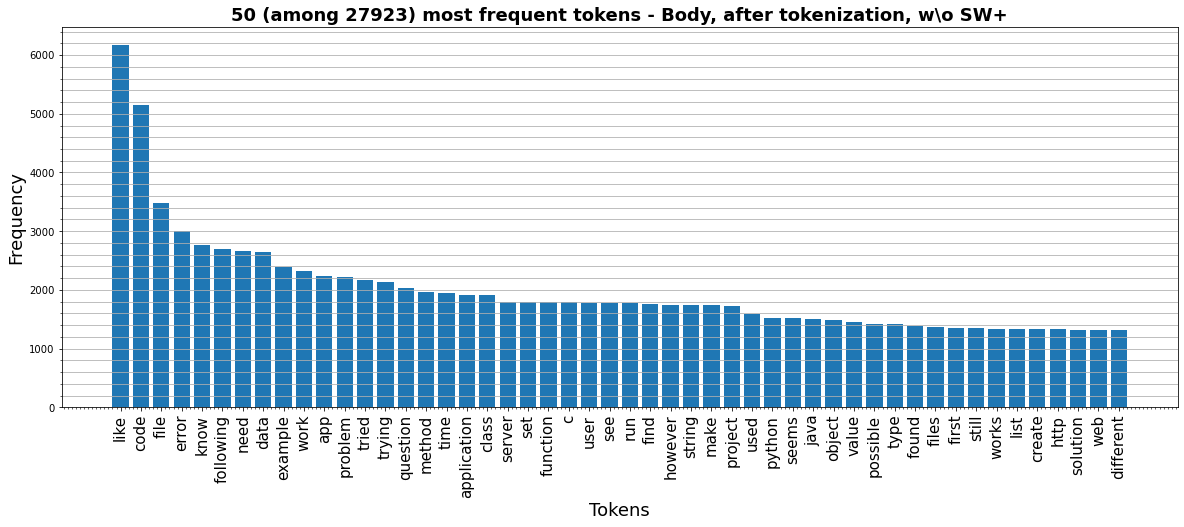

In [205]:
plot_most_freq_tokens(nb=50, tokenized_serie=title_tokens_sw, title='Title, after tokenization, w\o SW+', rotation='vertical')
plot_most_freq_tokens(nb=50, tokenized_serie=body_tokens_sw, title='Body, after tokenization, w\o SW+', rotation='vertical')

Prenons le temps de vérifier simplement si le retrait des SW de langue anglaise n'a pas vidé certains titres/corps de texte de leur contenu. Au quel cas, il faudrait supprimer les lignes correspondantes des nos colonnes de données textuelles.

In [206]:
0 in title_tokens_sw.apply(lambda x : len(x)).value_counts().index, 0 in body_tokens_sw.apply(lambda x : len(x)).value_counts().index

(True, True)

Les lignes ci-dessous servent en cas de déplétion totale de certains documents.

In [207]:
indx_doc_vides = []
for serie in [title_tokens_sw, body_tokens_sw] :
    if 0 in serie.apply(lambda x : len(x)).value_counts().index :
        print(f'Il y a bien des documents désormais vides suite au retrait des SW au sein de la série {serie.name}')
        indx_doc_0 = serie[serie.apply(lambda x : len(x)==0)].index.values
        print(f'Ils sont au nombre de {len(indx_doc_0)}, et les voici :\n{indx_doc_0}')
        indx_doc_vides = np.concatenate((indx_doc_vides, indx_doc_0))
del indx_doc_0
if len(indx_doc_vides)>0 :
    print('On supprime les documents correspondants des colonnes.')
    title_tokens_sw.drop(index=indx_doc_vides, inplace=True)
    body_tokens_sw.drop(index=indx_doc_vides, inplace=True)
    # On le fait également pour les séries correspondant uniquement à la tokenisation, car pour comparer approche supervisée et non supervisée, il faudar travailler sur les mêmes documents
    tags_tokens.drop(index=indx_doc_vides, inplace=True)
    title_tokens.drop(index=indx_doc_vides, inplace=True)
    body_tokens.drop(index=indx_doc_vides, inplace=True)
del indx_doc_vides

Il y a bien des documents désormais vides suite au retrait des SW au sein de la série Title
Ils sont au nombre de 3, et les voici :
[12769 26625 27105]
Il y a bien des documents désormais vides suite au retrait des SW au sein de la série Body
Ils sont au nombre de 2, et les voici :
[4285 4642]
On supprime les documents correspondants des colonnes.


# 
# <u><b>V) Lemmatisation.</b></u>
Il nous faut maintenant lemmatiser nos colonnes <i>Title</i> et <i>Body</i>, afin de faire diminuer le nombre de mots de même racine et de même fonction grammaticales, mais dont l'accord différe, créant ainsi artificiellement de la diversité lexicale.

On sait cependant que la lemmatisation peut faire disparaître certains termes (comme par exemple <i>ios</i>, <i>css</i>, <i>js</i>, etc) en les confondant avec des noms communs. Il faut donc les protéger, <i>a fortiori</i> quand ils sont présents parmis les mots-clefs de <i>Tags</i>

Dressons une listes de tous les suffixes qui pourraient subbir la lemmatisation :

In [208]:
liste_suffixes = flatten_serie(tags_tokens)[flatten_serie(tags_tokens).apply(lambda x : np.logical_and(x.endswith('s'),len(x)<5))].unique()
# Affichage
liste_suffixes

array(['maps', 'ios', 'css', 'xls', 'ssis', 'cvs', 'dvcs', 'tags', 'iis',
       'cors', 'this', 'puts', 'gfs', 'mips', 'ucs', 'sass', 'gis', 'xss',
       'tfs', 'dns', 'dos', 'ntfs', 'rxjs', 'ssms', 'jaas', 'aes', 'tabs',
       'sms', 'rows', 'clrs', 'gps', 'ads', 'nfs', 'jms', 'ps', 'paas',
       'deis', 'less', 'fs', 'blas', 'ls', 'r.js', 'axes', 'ejs', 'tns',
       'hdfs', 'sys', 'jags', 'jks', 'jess', 'saas', 'bits', 'pecs',
       'vfs', 'rss', 'lis', 'adfs', 'ifs', 'ips', 'xts', 'bots', 'bids',
       'ddms', 'cqrs', 'cifs', 'jobs', 'days', 'jss', 'msys', 'tms', 's',
       'lts', 'axis', 'mms', 'jls', 'cas', 'dcos'], dtype=object)

On peut donc chercher parmis l'ensemble des mots-clef tous ceux qui terminent par de tels suffixes.

In [209]:
liste_terminants = flatten_serie(tags_tokens)[flatten_serie(tags_tokens).apply(lambda x : np.sum([x.endswith(w) for w in liste_suffixes])>0)].unique()
# Affichage
liste_terminants

array(['common-tasks', 'web-services', 'maps', ..., 'jasmine-matchers',
       'ios-universal-links', 'multiple-monitors'], dtype=object)

Puis réduire ce tableau à ceux qui seraient bel et bien modifiés par la lemmatisation (perte du s terminal, notamment), et que seraient donc ceux à protéger.

In [210]:
a_proteger = liste_terminants[liste_terminants != np.array([lemmatizer.lemmatize(w, 'n') for w in liste_terminants])]
# Affichage
a_proteger

array(['maps', 'windows', 'dependencies', 'generics', 'templates',
       'https', 'collections', 'ios', 'css', 'numbers', 'variables',
       'specifications', 'flags', 'xls', 'lines', 'graphics', 'operators',
       'coordinates', 'loops', 'events', 'arrays', 'filenames',
       'closures', 'passwords', 'transactions', 'types', 'parameters',
       'pointers', 'chunks', 'methods', 'cookies', 'forms', 'pandas',
       'idioms', 'implements', 'cvs', 'icons', 'sockets', 'properties',
       'macros', 'assemblies', 'tags', 'conventions', 'constraints',
       'preferences', 'credentials', 'arguments', 'triggers', 'equals',
       'routes', 'keras', 'charts', 'options', 'drivers',
       'microprocessors', 'comments', 'signals', 'duplicates',
       'bookmarks', 'constants', 'frameworks', 'controls', 'warnings',
       'packages', 'entities', 'statistics', 'iis', 'attributes',
       'states', 'sequences', 'grails', 'containers', 'spaces', 'colors',
       'delegates', 'protocols', 'liter

In [211]:
#tags_tokens_sw_lem = tags_tokens_sw.apply(lambda x : [lemmatizer.lemmatize(w) for w in x])
list_lambda_x = [lambda x : [lemmatizer.lemmatize(w, 'n') for w in x if w not in a_proteger], 
                 lambda x : [lemmatizer.lemmatize(w, 'v') for w in x], 
                 lambda x : [lemmatizer.lemmatize(w, 'a') for w in x]]
pbar = tqdm(total=2)
title_tokens_sw_lem = title_tokens_sw.apply(lambda x : [lemmatizer.lemmatize(w) for w in x])
pbar.update(1)
body_tokens_sw_lem = body_tokens_sw.apply(lambda x : [lemmatizer.lemmatize(w) for w in x])
pbar.update(1)
del pbar

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.06s/it]

### Puis on affiche le nouveau "top 100" des mots les plus fréquents pour chaque colonne à ce stade du prétraitement.

<ipython-input-156-7846b9ad72bb>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axe.set_xticklabels(labels=serie.value_counts()[:nb].index, rotation=rotation, fontsize=15)


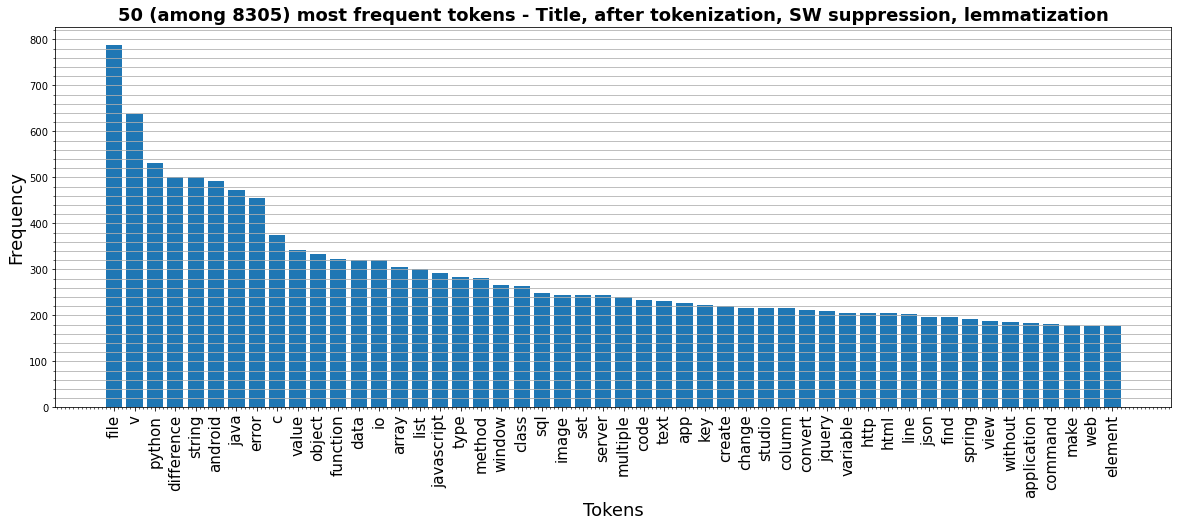

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [04:25<00:00, 132.57s/it]


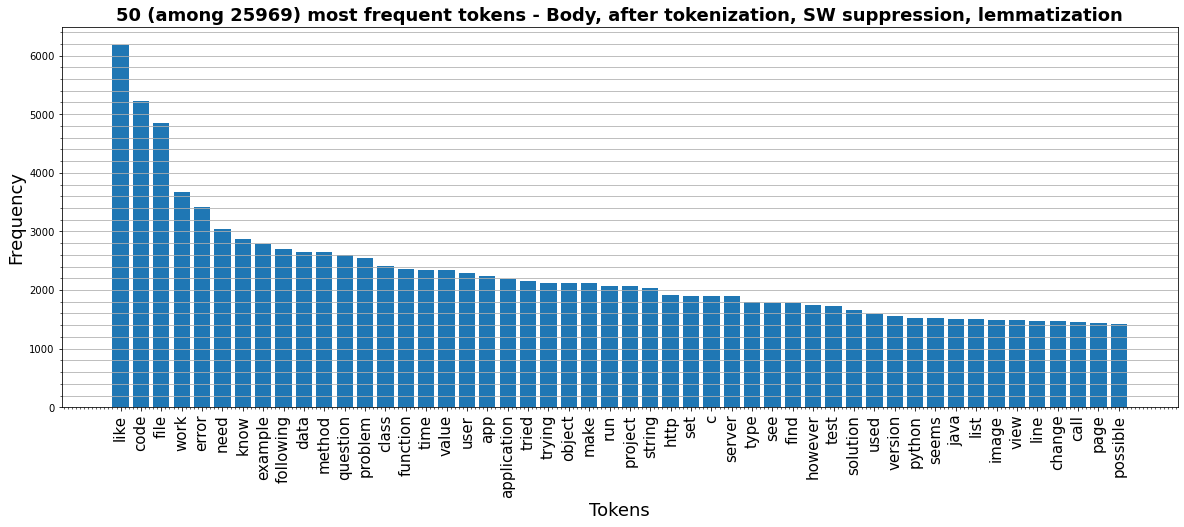

In [212]:
#plot_most_freq_tokens(nb=50, tokenized_serie=tags_tokens_sw_lem, title='Tags, after tokenization, w\o SW+, lemmatization')
plot_most_freq_tokens(nb=50, tokenized_serie=title_tokens_sw_lem, title='Title, after tokenization, SW suppression, lemmatization', rotation='vertical')
plot_most_freq_tokens(nb=50, tokenized_serie=body_tokens_sw_lem, title='Body, after tokenization, SW suppression, lemmatization', rotation='vertical')

### Les top 100 de tokens les plus fréquents sont quasiment inchangés. De plus, le nombre total de tokens unique (indiqué en légende des deux graphes précédent) a très peu diminué suite à cette opération. En effet :

In [213]:
for serie_lem, serie in zip([title_tokens_sw_lem, body_tokens_sw_lem],[title_tokens_sw, body_tokens_sw]):
    print(f'Pour {serie.name}, on a conservé {100*len(flatten_serie(serie_lem).value_counts().index)/len(flatten_serie(serie).value_counts().index) : >3.1f}% des tokens uniques à l`issue de la lemmatisation.')
del serie_lem, serie

Pour Title, on a conservé 92.5% des tokens uniques à l`issue de la lemmatisation.
Pour Body, on a conservé 93.0% des tokens uniques à l`issue de la lemmatisation.


### 
### Le nettoyage du texte peut être considéré comme terminé. Avant de passer à la suite, on prend simplement le temps de renommer de façon plus courte les différentes séries pour faciliter notre manipulations des variablesn, et de les stocker au sein d'un Dataframe

In [214]:
# On modifie leur paramètre 'name' en conséquence
tags_tokens.rename('Tags tokens', inplace=True)
title_tokens.rename('Title tokens', inplace=True)
body_tokens.rename('Body tokens', inplace=True)
title_tokens_sw_lem.rename('Title tokens sw lem', inplace=True)
body_tokens_sw_lem.rename('Body tokens sw lem', inplace=True)
# Création d'un Datafram contenant les listes de tokens des trois colonnes
df_tokens = pd.DataFrame(data={
    serie.name : serie.values for serie in [tags_tokens, title_tokens, body_tokens, title_tokens_sw_lem, body_tokens_sw_lem]
}, 
                         index=tags_tokens.index)
# Affichage de contrâole
df_tokens

,Tags tokens,Title tokens,Body tokens,Title tokens sw lem,Body tokens sw lem
2,"[c#, .net, linq, datatable, .net-3.5]","[linq, query, on, a, datatable]","[i, m, trying, to, perform, a, linq, query, on...","[linq, query, datatable]","[trying, perform, linq, query, datatable, obje..."
3,"[c++, performance, optimization, stl, c++-faq]","[how, to, overload, std, swap]","[std, swap, is, used, by, many, std, container...","[overload, std, swap]","[std, swap, used, many, std, container, std, l..."
4,"[c, file, directory, cross-platform, common-ta...","[how, do, you, get, a, directory, listing, in, c]","[how, do, you, scan, a, directory, for, folder...","[directory, listing, c]","[scan, directory, folder, file, c, need, cross..."
5,"[c#, .net, wcf, web-services, datatable]","[returning, datatables, in, wcf, net]","[i, have, a, wcf, service, from, which, i, wan...","[returning, datatables, wcf, net]","[wcf, service, return, datatable, know, often,..."
6,"[c#, .net, performance, datetime, timer]","[is, datetime, now, the, best, way, to, measur...","[i, need, to, find, a, bottleneck, and, need, ...","[datetime, best, measure, function, performance]","[need, find, bottleneck, need, accurately, pos..."
...,...,...,...,...,...
27120,"[python, pandas, dataframe, slice, multi-index]","[select, rows, in, pandas, multiindex, dataframe]","[what, are, the, most, common, pandas, ways, t...","[select, row, panda, multiindex, dataframe]","[common, panda, way, select, filter, row, data..."
27121,"[android, kotlin, kotlin-coroutines, coroutine...","[suspend, function, callgetapi, should, be, ca...","[i, am, calling, suspended, function, from, on...","[suspend, function, callgetapi, called, corout...","[calling, suspended, function, oncreate, suspe..."
27123,"[javascript, reactjs, typescript, lodash, sets...","[can, t, perform, a, react, state, update, on,...","[i, am, writing, an, application, in, react, a...","[perform, react, state, update, unmounted, com...","[writing, application, react, unable, avoid, s..."
27124,"[linux, wpf, .net-core, desktop-application, ....","[can, wpf, applications, be, run, in, linux, o...","[microsoft, announced, .net, core, comes, with...","[wpf, application, run, linux, mac, .net, core]","[microsoft, announced, .net, core, come, wpf, ..."


In [215]:
# Sauvegarde des tags tokenisés
if sauvegarde_fichiers :
    df_tokens['Tags tokens'].to_csv(abs_path_cache + 'serie_tags.csv')
    df_tokens['Title tokens'].to_csv(abs_path_cache + 'serie_title.csv')
    df_tokens['Body tokens'].to_csv(abs_path_cache + 'serie_body.csv')
    df_tokens['Title tokens sw lem'].to_csv(abs_path_cache + 'serie_titlenet.csv')
    df_tokens['Body tokens sw lem'].to_csv(abs_path_cache + 'serie_bodynet.csv')

# 
# <u><b>VI) Préparation à l'extraction des <i>features</i>.</b></u>
### Avant de passer à l'analyse exploratoire mono ou multi-variée, il nous faut produire des données numériques à partir des données textuelles, et ainsi fournir à notre modèles des features exploitables. Mais pour celà, il nous faut trancher entre <i>Title</i> et/ou <i>Body</i>, car on ne peut pas traîner d'avantage deux séries aussi lourdes sur toutes nos prochaines étapes, particulièrement pour la vectorisation (CountVectoriser, TF-IDF, etc).
### 
## <u><b>VI.1) <i>Title</i> ou <i>Body</i> ou les deux ?</b></u>
### Nous aimlerions garder uniquement <i>Title</i>, car il contient beaucoup - de mots par ligne, ce qui permettrait de faire des calculs beaucoup plus rapides. En revanche, rien ne nous garantit à ce stade que les infos contenues dans <i>Title</i> suffiront à faire une suggestion efficace de mots-clefs. Nous proposons donc deux alternative :
#### - ne considérer que les tokens de <i>Title</i>, qui contiennent moins d'informations mais permettent des temps de calculs plus courts ;
#### - utiliser une méthode précise qui cherche l'ensemble de tokens minimal, entre <i>Title</i> ou <i>Body</i> ou leur union, contenant le maximum de mots-clefs.

### 
### <u><b>VI.1.a) Ne retenir que les tokens de <i>Title</i>.</b></u>
### C'est la solution de facilité, qui permet néanmoins de faire une base de travail facielement compréhensible et moins coûteuse en calculs que l'alternative.

### 
### <u><b>VI.1.b) Recherche plus précise d'un ensemble minimal de tokens.</b></u>
### La méthode est la suivante suivante :
### (1) Pour chaque ligne, nous regardons quels mots-clefs parmis les tokens de <i>Tags</i> sont également présents dans ceux de :
#### - <i>Title</i> ;
#### - <i>Body</i> ;
#### - ainsi que l'UNION de ceux présents dans ces deux colonnes [au sens du ET logique].
### (2) Pour chaque liste de mot-clefs de <i>Tags</i>, on aura donc 3 listes de même longueur contenant les booléens de leur présence au sein de chacun des 3 enembles précédent [True si présent, False sinon]. Nous faison la somme des booléens au sein de chaque liste, ce que python interprétera comme une somme arithmétique de 0 et/ou de 1 : le résultat sera donc égal au nombre de mots-clefs présents dans l'ensemble correspondant.
### (3) Nous comparerons ces valeurs, et retiendrons la liste de token correspondant à l'ensemble contenant le plus de mos-clefs. En cas d'égalité, on retiendra l'ensemble contenant le moins de token.
### <b>(<u>NB :</u> On soulignera l'utilité d'avoir considéré l'union de <i>Title</i> et <i>Body</i>, qui permet de tenir compte des cas où <i>Title</i> et <i>Body</i> ne contiennent pas les mêms mots-clefs, auquel cas choisir entre les deux engendrerait de la perte d'information.)</b>

#### 
### Commençons par l'étape (1) : 
### Déterminer, pour chaque liste de mots-clefs de <i>Tags</i>, la liste des booléens de présence au sein de chacun des trois ensemble précédents.

In [216]:
### On parcourt les listes de mots clefs de tags, et on crée de nouvelles lites de Booléens de présence des mots clefs de tags sont présents dans :
# la liste correspondante de tokens de Title
tags_in_title = np.array([np.array([True if w in np.unique(x) else False for w in values]) for values, x in zip(df_tokens[df_tokens.columns[0]].values, df_tokens[df_tokens.columns[1]].values)])
# la liste correspondante de tokens de Title
tags_in_body = np.array([np.array([True if w in np.unique(x) else False for w in values]) for values, x in zip(df_tokens[df_tokens.columns[0]].values, df_tokens[df_tokens.columns[2]].values)])
### Puis on créer un Dataframe contenant ces listes numériques pour mieux visualiser le résultat
df_presence = pd.DataFrame(data = {'Presents dans title': list(tags_in_title), 'Presents dans body': list(tags_in_body), 'Presents dans les deux':list(tags_in_title+tags_in_body)}, index=tags_tokens.index)
# Affichage de contrôle
df_presence

,Presents dans title,Presents dans body,Presents dans les deux
2,"[False, False, True, True, False]","[False, False, True, True, False]","[False, False, True, True, False]"
3,"[False, False, False, False, False]","[False, False, False, False, False]","[False, False, False, False, False]"
4,"[True, False, True, False, False]","[True, False, True, False, False]","[True, False, True, False, False]"
5,"[False, False, True, False, False]","[False, False, True, False, True]","[False, False, True, False, True]"
6,"[False, False, True, True, False]","[False, False, True, False, False]","[False, False, True, True, False]"
...,...,...,...
27120,"[False, True, True, False, False]","[False, True, True, True, False]","[False, True, True, True, False]"
27121,"[False, False, False, True, False]","[False, False, False, True, False]","[False, False, False, True, False]"
27123,"[False, False, False, False, False]","[False, False, False, False, True]","[False, False, False, False, True]"
27124,"[True, True, False, False, False]","[True, True, False, False, False]","[True, True, False, False, False]"


#### 
### Passons à l'étape (2) : 
### Faisons la somme des booléens à l'interieur des listes les contenant pour obtenir le nombre de mots-clef contenus.

In [217]:
# On créer un Dataframe contenant trois colonnes, chacune contenant la somme des booléens de chaque ligne des colonnes précédentes
df_add = pd.DataFrame(data = {
    'Nbr de mots-clef dans Title': df_presence['Presents dans title'].apply(lambda x : x.sum()), 
    'Nbr de mots-clef dans body': df_presence['Presents dans body'].apply(lambda x : x.sum()), 
    'Nbr de mots-clef dans les deux': df_presence['Presents dans les deux'].apply(lambda x : x.sum())
}, index=tags_tokens.index)
# Affichage
df_add

,Nbr de mots-clef dans Title,Nbr de mots-clef dans body,Nbr de mots-clef dans les deux
2,2,2,2
3,0,0,0
4,2,2,2
5,1,2,2
6,2,1,2
...,...,...,...
27120,2,3,3
27121,1,1,1
27123,0,1,1
27124,2,2,2


#### 
### Passons à l'étape (3) : 
### On compare ces nombres pour déterminer l'ensemble minimal de tokens qui contient le maximum de mots-clefs. Grâce à l'ordre des colonnes précédentes, ainsi qu'à la fonction argmax(), on s'assure qu'en cas d'égalité de nombre, c'est toujours la colonne qui contient de base le moins de token qui l'emporte.

In [235]:
### On parcourt les indices de la B2D, et on recherche quelle colonne correspond à l'ensemble contenant le plus de mots-clef
colonnes = [df_add.loc[n].argmax() for n in df_add.index]
# On affiche d'ailleurs grâce à cette liste le nom de l'ensemble retenu
df_resume = pd.concat([df_add, pd.Series(df_presence.columns[colonnes].values, index=df_add.index, name='Maximum de mots-clef présents dans l`ensemble :')], axis=1)
# Affichage
df_resume

,Nbr de mots-clef dans Title,Nbr de mots-clef dans body,Nbr de mots-clef dans les deux,Maximum de mots-clef présents dans l`ensemble :
2,2,2,2,Presents dans title
3,0,0,0,Presents dans title
4,2,2,2,Presents dans title
5,1,2,2,Presents dans body
6,2,1,2,Presents dans title
...,...,...,...,...
27120,2,3,3,Presents dans body
27121,1,1,1,Presents dans title
27123,0,1,1,Presents dans body
27124,2,2,2,Presents dans title


In [238]:
df_resume['Maximum de mots-clef présents dans l`ensemble :'].value_counts()#['Maximum de mots-clef présents dans l`ensemble :'].describe()

Presents dans title       6516
Presents dans body        5691
Presents dans les deux    1351
Name: Maximum de mots-clef présents dans l`ensemble :, dtype: int64

### Pour la suite des opérations, on rajoute une colonne dans la Dataframe des tokens, qui contient la concatenation des tokens de <i>Title</i> et de <i>Body</i>

In [71]:
df_tokens['Title+Body tokens'] = [np.concatenate((a,b)) for a,b in zip(df_tokens[df_tokens.columns[1]], df_tokens[df_tokens.columns[2]])]#df_tokens[df_tokens.columns[1]] + df_tokens[df_tokens.columns[2]]
df_tokens['Title+Body tokens sw lem'] = [np.concatenate((a,b)) for a,b in zip(df_tokens[df_tokens.columns[3]], df_tokens[df_tokens.columns[4]])]#df_tokens[df_tokens.columns[3]] + df_tokens[df_tokens.columns[4]]
# Affichage
df_tokens

,Tags tokens,Title tokens,Body tokens,Title tokens sw lem,Body tokens sw lem,Title+Body tokens,Title+Body tokens sw lem
2,"[c#, .net, linq, datatable, .net-3.5]","[linq, query, on, a, datatable]","[i, m, trying, to, perform, a, linq, query, on...","[linq, query, datatable]","[trying, perform, linq, query, datatable, obje...","[linq, query, on, a, datatable, i, m, trying, ...","[linq, query, datatable, trying, perform, linq..."
3,"[c++, performance, optimization, stl, c++-faq]","[how, to, overload, std, swap]","[std, swap, is, used, by, many, std, container...","[overload, std, swap]","[std, swap, used, many, std, container, std, l...","[how, to, overload, std, swap, std, swap, is, ...","[overload, std, swap, std, swap, used, many, s..."
4,"[c, file, directory, cross-platform, common-ta...","[how, do, you, get, a, directory, listing, in, c]","[how, do, you, scan, a, directory, for, folder...","[directory, listing, c]","[scan, directory, folder, file, c, need, cross...","[how, do, you, get, a, directory, listing, in,...","[directory, listing, c, scan, directory, folde..."
5,"[c#, .net, wcf, web-services, datatable]","[returning, datatables, in, wcf, net]","[i, have, a, wcf, service, from, which, i, wan...","[returning, datatables, wcf, net]","[wcf, service, return, datatable, know, often,...","[returning, datatables, in, wcf, net, i, have,...","[returning, datatables, wcf, net, wcf, service..."
6,"[c#, .net, performance, datetime, timer]","[is, datetime, now, the, best, way, to, measur...","[i, need, to, find, a, bottleneck, and, need, ...","[datetime, best, measure, function, performance]","[need, find, bottleneck, need, accurately, pos...","[is, datetime, now, the, best, way, to, measur...","[datetime, best, measure, function, performanc..."
...,...,...,...,...,...,...,...
27120,"[python, pandas, dataframe, slice, multi-index]","[select, rows, in, pandas, multiindex, dataframe]","[what, are, the, most, common, pandas, ways, t...","[select, row, panda, multiindex, dataframe]","[common, panda, way, select, filter, row, data...","[select, rows, in, pandas, multiindex, datafra...","[select, row, panda, multiindex, dataframe, co..."
27121,"[android, kotlin, kotlin-coroutines, coroutine...","[suspend, function, callgetapi, should, be, ca...","[i, am, calling, suspended, function, from, on...","[suspend, function, callgetapi, called, corout...","[calling, suspended, function, oncreate, suspe...","[suspend, function, callgetapi, should, be, ca...","[suspend, function, callgetapi, called, corout..."
27123,"[javascript, reactjs, typescript, lodash, sets...","[can, t, perform, a, react, state, update, on,...","[i, am, writing, an, application, in, react, a...","[perform, react, state, update, unmounted, com...","[writing, application, react, unable, avoid, s...","[can, t, perform, a, react, state, update, on,...","[perform, react, state, update, unmounted, com..."
27124,"[linux, wpf, .net-core, desktop-application, ....","[can, wpf, applications, be, run, in, linux, o...","[microsoft, announced, .net, core, comes, with...","[wpf, application, run, linux, mac, .net, core]","[microsoft, announced, .net, core, come, wpf, ...","[can, wpf, applications, be, run, in, linux, o...","[wpf, application, run, linux, mac, .net, core..."


### On déduit donc le tableau des indices [ligne, colonne] correspondant aux listes miniamles de tokens contenant le maximum de mots-clefs.

In [72]:
ind_col = np.array([df_tokens.index.values, df_tokens.columns[1:][colonnes].values, df_tokens.columns[3:][colonnes].values]).T
# Affichage
ind_col

array([[2, 'Title tokens', 'Title tokens sw lem'],
       [3, 'Title tokens', 'Title tokens sw lem'],
       [4, 'Title tokens', 'Title tokens sw lem'],
       ...,
       [27123, 'Body tokens', 'Body tokens sw lem'],
       [27124, 'Title tokens', 'Title tokens sw lem'],
       [27126, 'Body tokens', 'Body tokens sw lem']], dtype=object)

### On crée une pandas.Series contenant les listes correspondantes de tokens, et une autre contenant les listes correspondantes de tokens lemmatisés sans SW :

In [73]:
serie_tokens_2 = pd.Series(data=[df_tokens.loc[ind, col1] for ind,col1,col2 in ind_col], index=df_tokens.index, name='Tokens')
# Sauvegarde dans le cache
if sauvegarde_fichiers :
    serie_tokens_2.to_csv(abs_path_cache + 'serie_tokens_sol_alter.csv')
# Affichage
serie_tokens_2

2                          [linq, query, on, a, datatable]
3                           [how, to, overload, std, swap]
4        [how, do, you, get, a, directory, listing, in, c]
5        [i, have, a, wcf, service, from, which, i, wan...
6        [is, datetime, now, the, best, way, to, measur...
                               ...                        
27120    [what, are, the, most, common, pandas, ways, t...
27121    [suspend, function, callgetapi, should, be, ca...
27123    [i, am, writing, an, application, in, react, a...
27124    [can, wpf, applications, be, run, in, linux, o...
27126    [if, you, execute, the, following, statement, ...
Name: Tokens, Length: 13558, dtype: object

In [74]:
serie_tokens_3 = pd.Series(data=[df_tokens.loc[ind, col2] for ind,col1,col2 in ind_col], index=df_tokens.index, name='Tokens sw lem')
# Sauvegarde dans le cache
if sauvegarde_fichiers :
    serie_tokens_3.to_csv(abs_path_cache + 'serie_tokensnet_sol_alter.csv')
# Affichage
serie_tokens_3

2                                 [linq, query, datatable]
3                                    [overload, std, swap]
4                                  [directory, listing, c]
5        [wcf, service, return, datatable, know, often,...
6         [datetime, best, measure, function, performance]
                               ...                        
27120    [common, panda, way, select, filter, row, data...
27121    [suspend, function, callgetapi, called, corout...
27123    [writing, application, react, unable, avoid, s...
27124      [wpf, application, run, linux, mac, .net, core]
27126    [execute, following, statement, python, testin...
Name: Tokens sw lem, Length: 13558, dtype: object

In [75]:
# On élmine les variables devenues inutiles
del ind_col, colonnes, df_add, df_presence, tags_in_title, tags_in_body